In [3]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # "gpu" or "cpu"
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from dataclasses import dataclass
import matplotlib.pyplot as plt
import scipy.optimize as sciopt
import scipy.integrate as sciint
import h5py
import pathlib as path
import numpy as np

from jax_tqdm import scan_tqdm
from tqdm import tqdm
import time
import functools as ft
maindir = path.Path("/home/nickd/PyFluid")
gifdir   = maindir / "gifs"
exactdir = maindir / "exact_balsara"
checkdir = maindir / "checkpoints"
print(jax.devices("cpu"))
print(jax.devices("gpu"))
print(f'Using jax device {jax.devices()}')

[CpuDevice(id=0)]
[CudaDevice(id=0)]
Using jax device [CpuDevice(id=0)]


Compiling
Starting main run


100%|██████████| 150/150 [00:19<00:00,  7.60it/s]


Main Run Done
Final Step = 150, Final Time = 0.0575, Mean dt = 3.83366e-04
Avg. Cell Updates /s = 4.580585e+05
Mean Diffusion Steps = 6.00000e+00, Mean Diffusion Error = 1.16826e-14
Reynolds Number = 3.95044e+02


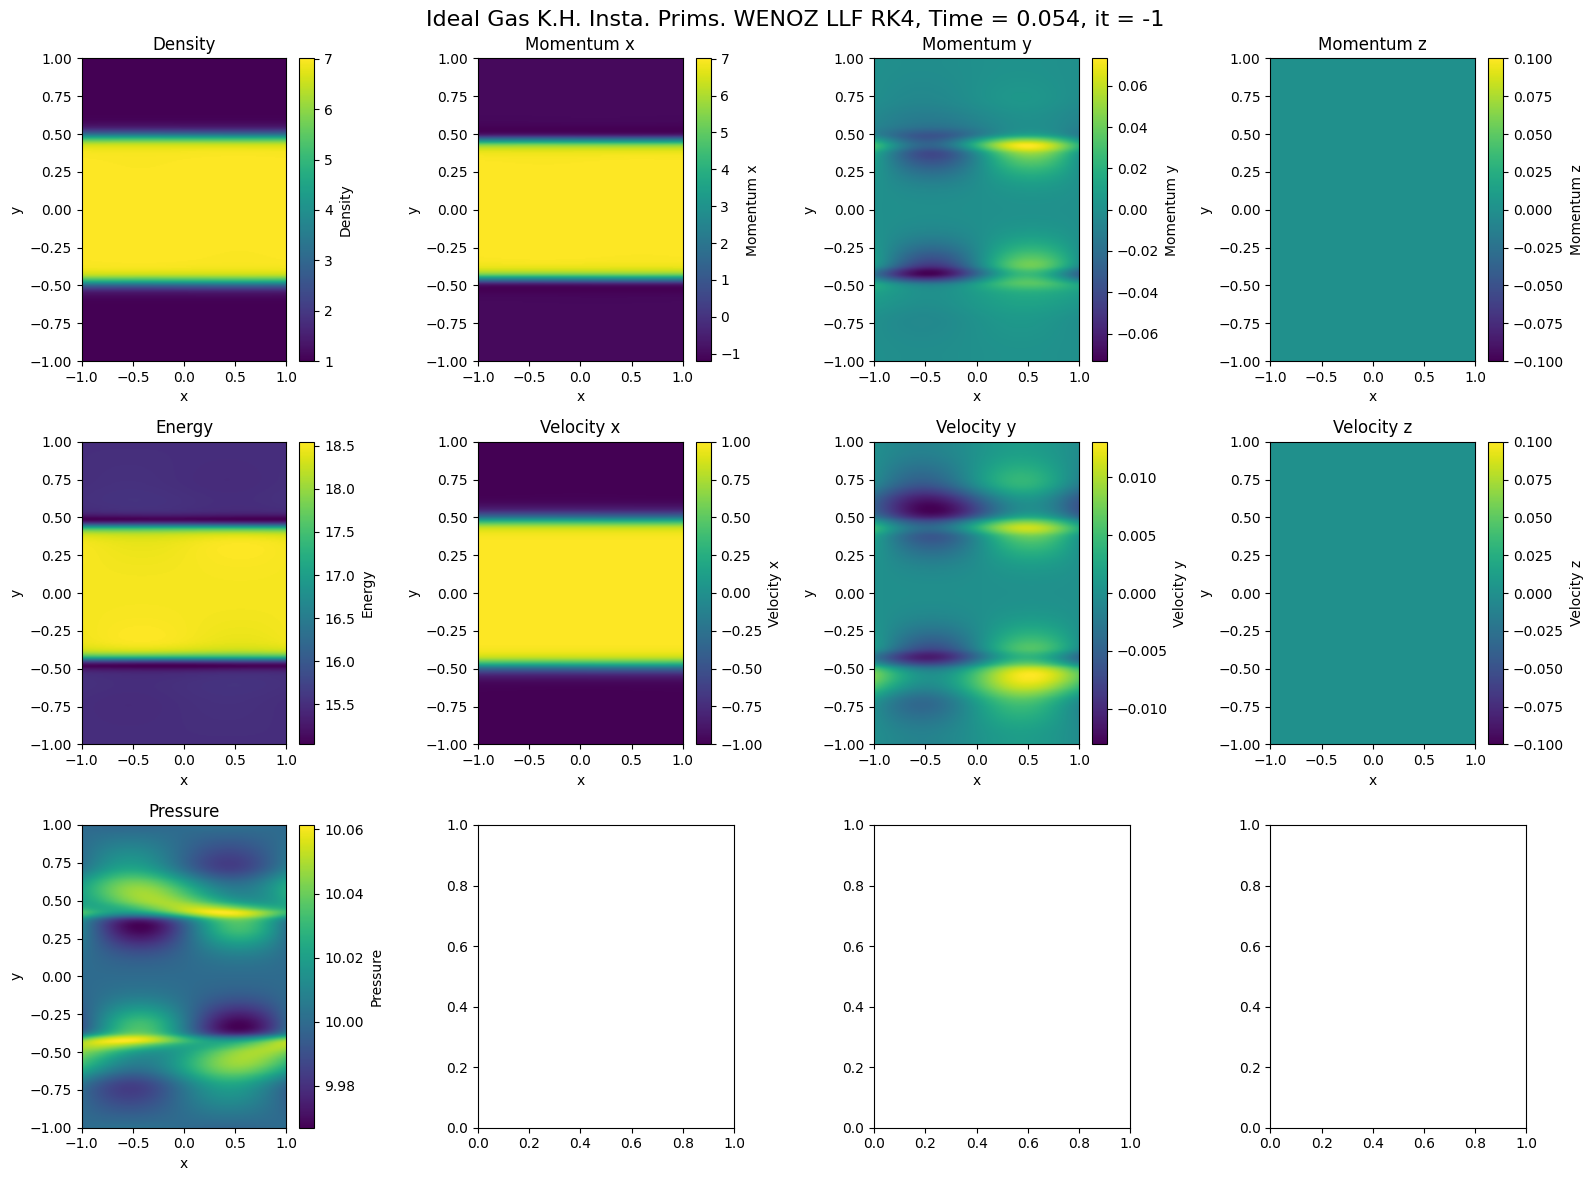

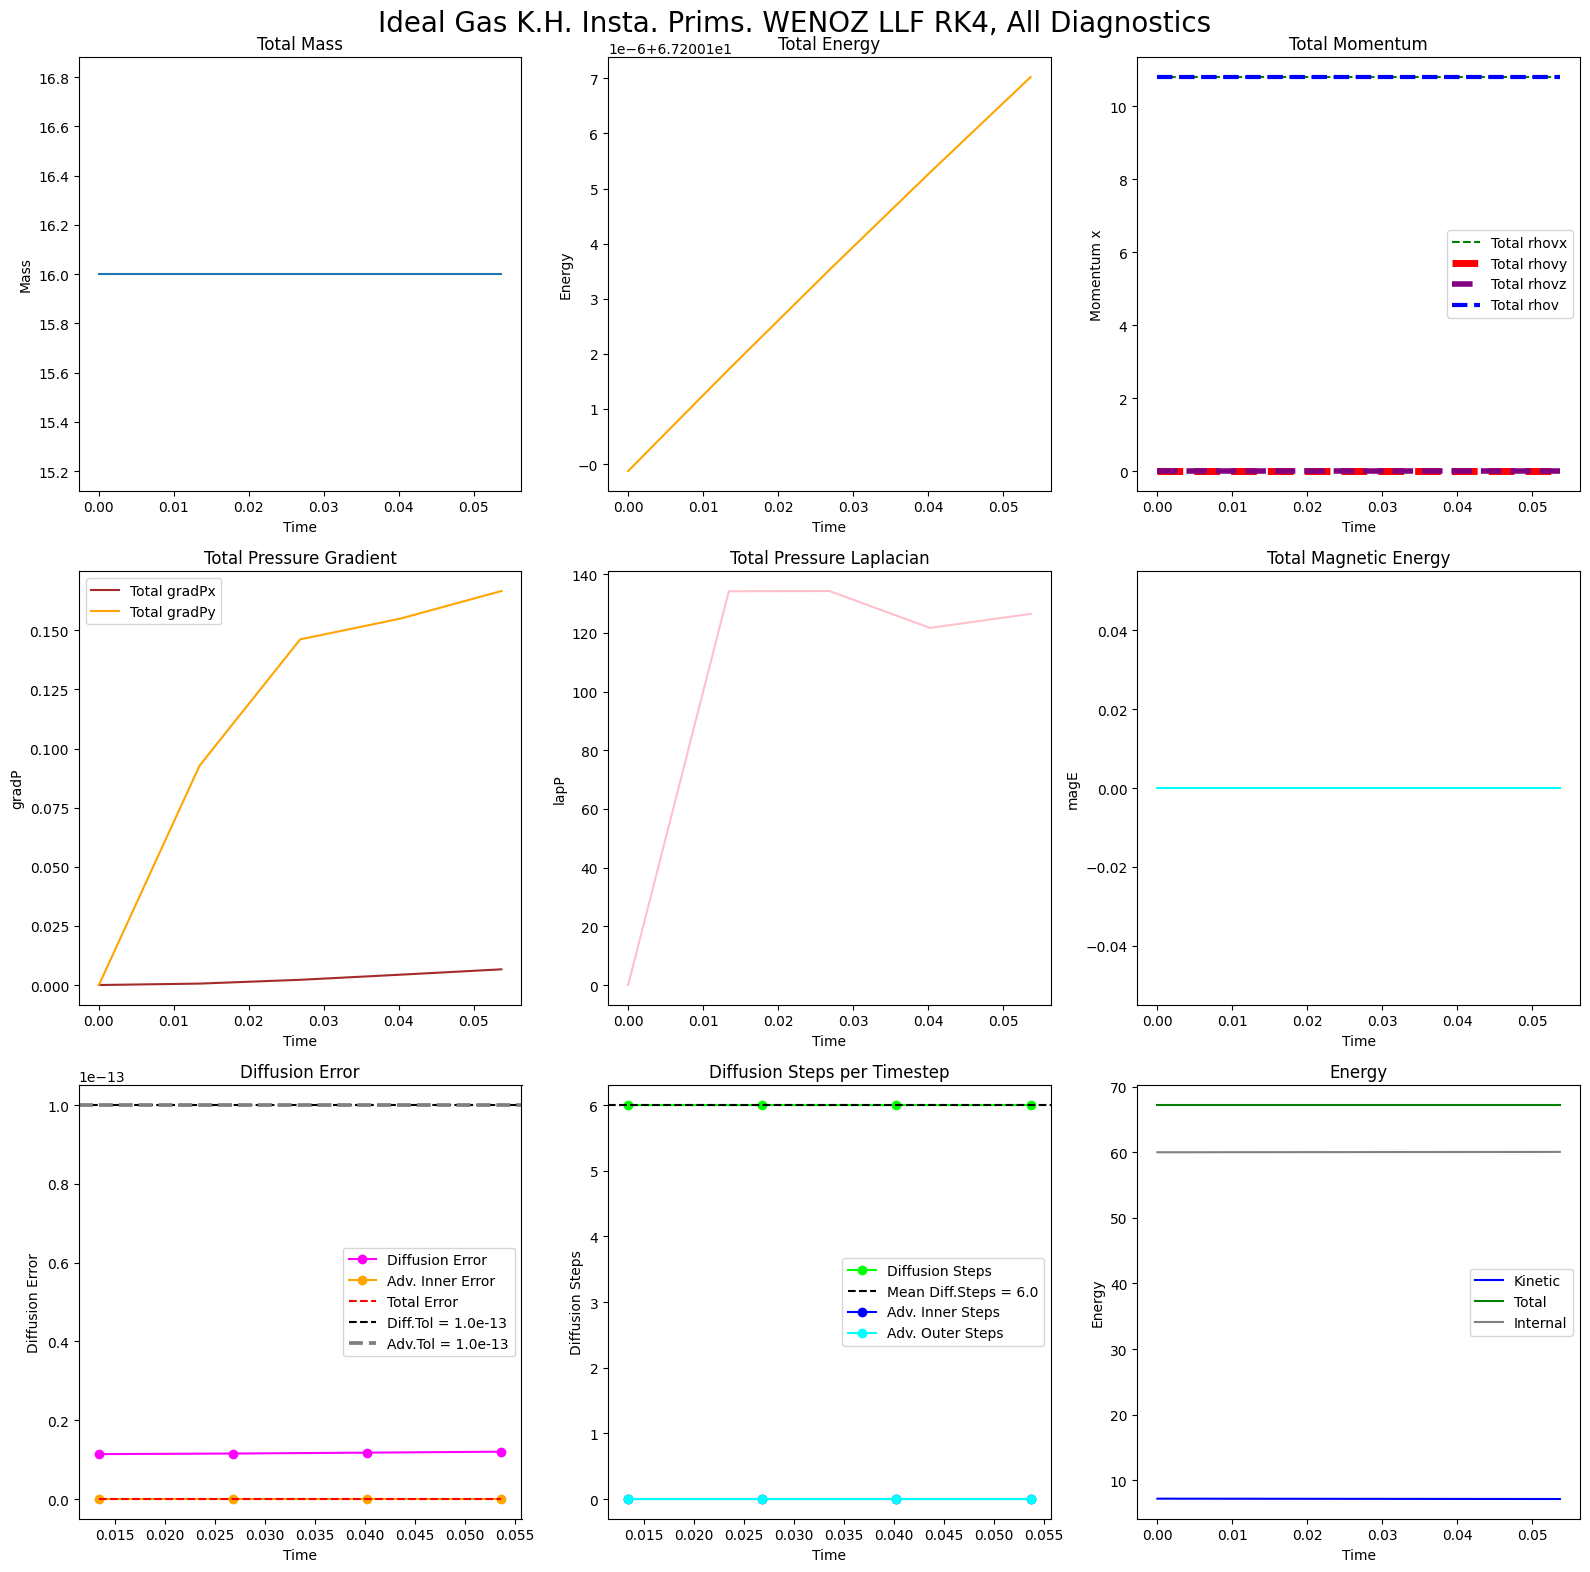

In [4]:
cl = 1.0 #speed of light in code units
cl2 = cl*cl;
#2D Dimension MHD, Compressible, Adiabatic, Viscous, Resistive, Finite Volume.
@jax.jit
def calc_sloplim_diff(a,b):
   return((a + b)/2)

@jax.jit
def calc_sloplim_minmod(a,b):
   return(jnp.where(jnp.sign(a) == jnp.sign(b), jnp.where(jnp.abs(a) < jnp.abs(b), a, b), 0.0))

@jax.jit
def calc_sloplim_superbee(a,b):
   return(jnp.maximum(0,jnp.minimum(2*jnp.abs(a),jnp.abs(b)),jnp.minimum(jnp.abs(a),2*jnp.abs(b))) \
                  *jnp.sign(a)*jnp.where(jnp.sign(a) == jnp.sign(b),1.0,0.0))

@jax.jit
def calc_sloplim_vanleer(a,b):
   out = (2*a*b)/(a+b + 1e-16)*jnp.where(jnp.sign(a) == jnp.sign(b),1.0,0.0)
   out = jnp.where(out>1e15,0.0,out)#handle inf/nan cases
   return(out)

@jax.jit
def calc_sloplim_mc(a,b):
   return(jnp.minimum(0.5*(a+b),2*jnp.abs(a),2*jnp.abs(b))*jnp.sign(a)*jnp.where(jnp.sign(a) == jnp.sign(b),1.0,0.0))



def calc_v4(p3f,selff):
   return (p3f - selff.presR)*np.sqrt((1 - selff.gammaex)/(selff.rhoR*(p3f + selff.gammaex*selff.presR)))

def calc_v3(p3f,selff):
   return ((selff.presL**selff.betaex) - (p3f**selff.betaex))*np.sqrt(((1 - selff.gammaex**2)*(selff.presL**(1/selff.gamma))/((selff.gammaex**2)*selff.rhoL)))

def calc_root_pres3(p3f,selff):
   return(calc_v3(p3f,selff) - calc_v4(p3f,selff))

def soft_dict_equal(a, b, tol=1e-12, exclude=None):
    """
    Compare two dictionaries that may contain arrays, floats, strings, bools.
    Prints mismatches and returns True if equal (within tolerance).

    exclude: iterable of keys to ignore during comparison.
    """
    same = True
    exclude = set(exclude or [])  # convert to set for fast lookup

    # 1. Check for missing or extra keys
    a_keys, b_keys = set(a.keys()), set(b.keys())
    if a_keys != b_keys:
        missing_in_a = b_keys - a_keys
        missing_in_b = a_keys - b_keys
        if missing_in_a:
            print(f"⚠️ Missing in first dict: {missing_in_a}")
        if missing_in_b:
            print(f"⚠️ Missing in second dict: {missing_in_b}")
        same = False

    # 2. Compare values for common keys
    for k in a_keys & b_keys:
        if k in exclude:
            continue  # skip excluded keys

        v1, v2 = a[k], b[k]

        if isinstance(v1, np.ndarray) and isinstance(v2, np.ndarray):
            if not np.allclose(v1, v2, rtol=tol, atol=tol):
                print(f"⚠️ Array mismatch for key '{k}':")
                print(f"   First:  {v1}")
                print(f"   Second: {v2}")
                same = False

        elif isinstance(v1, (float, np.floating)) and isinstance(v2, (float, np.floating)):
            if not np.isclose(v1, v2, rtol=tol, atol=tol):
                print(f"⚠️ Float mismatch for key '{k}': {v1} vs {v2}")
                same = False

        elif isinstance(v1, (int, bool, str)) and isinstance(v2, (int, bool, str)):
            if v1 != v2:
                print(f"⚠️ Value mismatch for key '{k}': {v1} vs {v2}")
                same = False

        else:
            # fallback for mismatched types
            if v1 != v2:
                print(f"⚠️ Type or value mismatch for key '{k}': {v1} ({type(v1)}) vs {v2} ({type(v2)})")
                same = False

    return same

@jax.jit
def calc_weno_omegas_jax(gf_Imm,gf_Im,gf_I,gf_Ip,gf_Ipp):
      wenoweights = jax.numpy.array([0.1,0.6,0.3])
      #gf_Imm, gf_Im, gf_I, gf_Ip, gf_Ipp = jax.numpy.array(gf_Imm), jax.numpy.array(gf_Im), jax.numpy.array(gf_I), jax.numpy.array(gf_Ip), jax.numpy.array(gf_Ipp)
      wenoeps =1e-8
      betaZ0 = (13/12) * (gf_Imm - 2*gf_Im + gf_I)**2 \
         + (1/4) * (gf_Imm - 4*gf_Im + 3*gf_I)**2
      betaZ1 = (13/12) * (gf_Im - 2*gf_I + gf_Ip)**2 \
         + (1/4) * (gf_Im - gf_Ip)**2
      betaZ2  = (13/12) * (gf_I - 2*gf_Ip + gf_Ipp)**2 \
         + (1/4) * (3*gf_I - 4*gf_Ip + gf_Ipp)**2
      tau5 = jnp.abs(betaZ0 - betaZ2)
      aux_alphaZ0 = 1.0 + tau5 /  (wenoeps + betaZ0)
      aux_alphaZ1 = 6.0 + tau5 /  (wenoeps + betaZ1)
      aux_alphaZ2 = 3.0 + tau5 /  (wenoeps + betaZ2)
      alphaZ0m = aux_alphaZ0 * wenoweights[0]
      alphaZ1m = aux_alphaZ1 * wenoweights[1]
      alphaZ2m = aux_alphaZ2 * wenoweights[2]
      alphaZ0p = aux_alphaZ0 * wenoweights[2]
      alphaZ1p = aux_alphaZ1 * wenoweights[1]
      alphaZ2p = aux_alphaZ2 * wenoweights[0]
      sum_alphaZm = alphaZ0m + alphaZ1m + alphaZ2m
      sum_alphaZp = alphaZ0p + alphaZ1p + alphaZ2p
      omegaZ0m = alphaZ0m / sum_alphaZm
      omegaZ1m = alphaZ1m / sum_alphaZm   
      omegaZ2m = alphaZ2m / sum_alphaZm
      omegaZ0p = alphaZ0p / sum_alphaZp
      omegaZ1p = alphaZ1p / sum_alphaZp
      omegaZ2p = alphaZ2p / sum_alphaZp
      return(omegaZ0m, omegaZ1m, omegaZ2m, omegaZ0p, omegaZ1p, omegaZ2p)

class PhysicsBase:
   @dataclass(frozen=True)
   class PhysicsModel:
         gamma: float
         kappa: float
         cs20: float
         boolmag: bool
         fluxct: bool
         voi: int
         diffparams: tuple
         diffloopparams: tuple
         booldiff: bool
         impadv: bool
         EOS_P: callable
         EOS_eps: callable
         EOS_cs2: callable
         calc_energy: callable
         calc_eps: callable
         
         con2prim: callable
         prim2con: callable
         calc_anfluxesX: callable
         calc_anfluxesY: callable
         calc_anfluxesX_diff: callable
         calc_anfluxesY_diff: callable
         calc_stress_grad_stdotv: callable
   def __init__(self,parent):
      self.parent = parent
      self.reli = parent.reli
      self.eosi = parent.eosi


      if self.eosi == 0:
         self.EOS_P = self.EOS_P_iso
         self.EOS_cs2 = self.EOS_cs2_iso
         self.EOSname = "Isotherm."
      if self.eosi == 1:
         self.EOS_P = self.EOS_P_ideal
         self.EOSname = "Ideal Gas"
      if self.eosi == 2:
         self.EOS_P = self.EOS_P_polytrope
         self.EOSname = "Polytrope"
      if self.eosi in [0,1,2]:
         self.EOS_eps = self.EOS_eps_isoidpoly
      if self.eosi in [1,2]:
         self.EOS_cs2 = self.EOS_cs2_idpoly
      if self.eosi not in [0,1,2]:
         raise ValueError("Equation of State not recognized.")
      if self.reli == 0: #Non-Relativistic
         self.calc_energy = self.calc_energy_NR
         self.calc_eps = self.calc_eps_NR
         self.con2prim = self.con2prim_NR
         self.prim2con = self.prim2con_NR
         self.calc_anfluxesX = self.calc_anfluxesX_NR
         self.calc_anfluxesY = self.calc_anfluxesY_NR
         self.calc_anfluxesX_diff = self.calc_anfluxesX_diff_NR
         self.calc_anfluxesY_diff = self.calc_anfluxesY_diff_NR
         self.calc_stress_grad_stdotv = self.calc_stress_grad_stdotv_NR
         self.relname = "Non-Rel."
      elif self.reli == 1: #Special Relativistic
         self.con2prim = self.con2prim_SR
         self.prim2con = self.prim2con_SR
         self.calc_anfluxesX = self.calc_anfluxesX_SR
         self.relname = "Spec.Rel."
   
   def init_diffpars(self):
      self.nu = self.parent.dx*np.sqrt(self.parent.cs20) #kinematic viscosity coefficient
      self.mu = self.nu*self.parent.rhob #dynamic viscosity coefficient
      self.lam = -(2/3)*self.mu #second viscosity coefficient
      self.eta = 1e-4 #resistivity coefficient
      self.diffparams = tuple([self.nu, self.mu, self.lam, self.eta])
      self.diffloopparams = tuple([self.parent.difftol, self.parent.diffstepmax])

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2))
   def EOS_cs2_iso(rhof,presf, physicsmodelf=None):
      return(presf/rhof)
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2))
   def EOS_cs2_idpoly(rhof,presf, physicsmodelf):
      return(physicsmodelf.gamma*presf/rhof)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2))
   def EOS_P_iso(rho,emd, physicsmodelf):
      return(physicsmodelf.cs20*rho)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2))
   def EOS_P_ideal(rho,emd, physicsmodelf):
      return((physicsmodelf.gamma - 1.0)*rho*emd)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2))
   def EOS_P_polytrope(rhof,emd, physicsmodelf):
      return(physicsmodelf.kappa*(rhof**physicsmodelf.gamma))
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1))
   def EOS_eps_isoidpoly(Pf, physicsmodelf):
      return(Pf/(physicsmodelf.gamma - 1.0))

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1))
   def calc_speeds(pvecf,physicsmodelf):
      #Calc wave speeds (cs2,cs2Ax,cs2A,cs2f)
      cs2out = jnp.zeros((4, pvecf.shape[1], pvecf.shape[2]))
      cs2out = cs2out.at[0, ...].set(physicsmodelf.EOS_cs2(pvecf[0, ...],pvecf[4, ...], physicsmodelf)) #sound speed squared
      cs2out = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[1,...].set(jnp.square(pvecf[5, ...])/pvecf[0, ...]), lambda x: x.at[1,...].set(0.0), cs2out)
      cs2out = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[2,...].set((jnp.square(pvecf[5:8, ...])).sum(axis=0)/pvecf[0, ...]), lambda x: x.at[2,...].set(0.0), cs2out)
      cs2out = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[3,...].set(0.5*(x[0, ...] + x[2, ...] + jnp.sqrt((x[0, ...] + x[2, ...])**2 - 4*x[0, ...]*x[1, ...]))), lambda x: x.at[3,...].set(x[0, ...]), cs2out)
      return(cs2out)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1))
   def con2prim_NR(uvecf,physicsmodelf):
      #print(np.min(uvecf[0,:]))
      rhoinv = 1.0/uvecf[0, ...];
      pvecout = jnp.zeros_like(uvecf)
      pvecout = pvecout.at[0, ...].set(uvecf[0, ...]) #density
      pvecout = pvecout.at[1:4, ...].set(uvecf[1:4, ...]*rhoinv) #velocities
      eps = PhysicsBase.calc_eps_NR(uvecf,physicsmodelf)
      pvecout = pvecout.at[4, ...].set(physicsmodelf.EOS_P(uvecf[0, ...], eps*rhoinv, physicsmodelf))
      pvecout = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[5:8, ...].set(uvecf[5:8, ...]), lambda x: x, pvecout)
      return(pvecout)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1))
   def prim2con_NR(pvecf,physicsmodelf):
      uvecout = jnp.zeros_like(pvecf)
      uvecout = uvecout.at[0, ...].set(pvecf[0, ...]) #density
      uvecout = uvecout.at[1:4, ...].set(pvecf[0, ...]*pvecf[1:4, ...]) #momentum
      uvecout = uvecout.at[4, ...].set(physicsmodelf.calc_energy(pvecf, physicsmodelf))
      uvecout = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[5:8, ...].set(pvecf[5:8, ...]), lambda x: x, uvecout)
      return(uvecout)
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1))
   def calc_energy_NR(pvecf, physicsmodelf):
      Energyout = physicsmodelf.EOS_eps(pvecf[4, ...], physicsmodelf) + 0.5*pvecf[0, ...]*jnp.square(pvecf[1:4, ...]).sum(axis=0)
      Energyout = jax.lax.cond(physicsmodelf.boolmag, lambda x: x + 0.5*jnp.square(pvecf[5:8, ...]).sum(axis=0), lambda x: x, Energyout)
      return(Energyout)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1))
   def calc_eps_NR(uvecf, physicsmodelf):
      eps = (uvecf[4, ...] - 0.5*jnp.square(uvecf[1:4, ...]).sum(axis=0)/uvecf[0, ...]) #internal energy
      eps = jax.lax.cond(physicsmodelf.boolmag, lambda x: x - 0.5*(jnp.square(uvecf[5:8, ...]).sum(axis=0)), lambda x: x, eps)
      return(eps)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2))
   def calc_anfluxesX_NR(uvecf, pvecf, physicsmodelf):
      fluxvecf = jnp.zeros_like(uvecf)
      fluxvecf = fluxvecf.at[0, ...].set(uvecf[1, ...]) #mass flux
      fluxvecf = fluxvecf.at[1:4, ...].set(uvecf[1, None, ...]*pvecf[1:4, ...])
      fluxvecf = fluxvecf.at[1, ...].add(pvecf[4, ...]) #corrections to x flux
      fluxvecf = fluxvecf.at[4, ...].set((uvecf[4, ...] + pvecf[4, ...])*pvecf[1, ...])   #energy flux
      if physicsmodelf.boolmag:
         metot = 0.5*jnp.square(pvecf[5:8, ...]).sum(axis=0)
         fluxvecf = fluxvecf.at[1:4, ...].add(-pvecf[5, None, ...]*pvecf[5:8, ...]) #momentum flux
         fluxvecf = fluxvecf.at[1, ...].add(metot)
         fluxvecf = fluxvecf.at[4, ...].add(metot*pvecf[1, ...] - pvecf[5, ...]*jnp.sum(pvecf[5:8, ...]*pvecf[1:4, ...], axis=0)) #energy flux
         fluxvecf = fluxvecf.at[5, ...].set(0.0)
         fluxvecf = fluxvecf.at[6:8, ...].set(pvecf[6:8, ...]*pvecf[1, ...] - pvecf[5, None, ...]*pvecf[2:4, ...]) #By,Bz flux
      return(fluxvecf)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2))
   def calc_anfluxesY_NR(uvecf, pvecf, physicsmodelf): 
      fluxvecf = jnp.zeros_like(uvecf)
      fluxvecf = fluxvecf.at[0, ...].set(uvecf[2, ...]) #mass flux
      fluxvecf = fluxvecf.at[1:4, ...].set(uvecf[2, None, ...]*pvecf[1:4, ...])
      fluxvecf = fluxvecf.at[2, ...].add(pvecf[4, ...])  #corrections to y flux
      fluxvecf = fluxvecf.at[4, ...].set((uvecf[4, ...] + pvecf[4, ...] )*pvecf[2, ...])  #energy flux
      if physicsmodelf.boolmag:
         metot = 0.5*jnp.square(pvecf[5:8, ...]).sum(axis=0)
         fluxvecf = fluxvecf.at[1:4, ...].add(-pvecf[6, None, ...]*pvecf[5:8, ...]) #momentum flux
         fluxvecf = fluxvecf.at[2, ...].add(metot)
         fluxvecf = fluxvecf.at[4, ...].add(metot*pvecf[2, ...] - pvecf[6, ...]*jnp.sum(pvecf[5:8, ...]*pvecf[1:4, ...], axis=0)) #energy flux
         fluxvecf = fluxvecf.at[5:8:2, ...].set(pvecf[5:8:2, ...]*pvecf[2, ...] - pvecf[6, None, ...]*pvecf[1:4:2, ...]) #Bx,Bz flux
         fluxvecf = fluxvecf.at[6, ...].set(0.0) # By flux
      return(fluxvecf)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(4,5))
   def calc_anfluxesX_diff_NR(uvecf,pvecf,dx_stressf, stressdotv,gridparamsf, physicsmodelf):
      ng = gridparamsf.ng
      fluxvecf = jnp.zeros_like(uvecf)
      fluxvecf = fluxvecf.at[1:4,ng:-ng,ng:-ng].set(-dx_stressf[:,0,ng:-ng,ng:-ng]);
      fluxvecf = fluxvecf.at[4,ng:-ng,ng:-ng].set(-jnp.gradient(stressdotv[0, ...],gridparamsf.dx,axis=0)[ng:-ng,ng:-ng])
      return(fluxvecf)
      #fluxvecf[4,self.imask]  += -self.eta*np.square(np.gradient(pvecf[5:8,:],self.dx,axis=1)).sum(axis=0)[self.imask] #resistive heating
      #fluxvecf[5:8,self.imask] = -self.eta*np.gradient(np.gradient(pvecf[5:8,:],self.dx,axis=1),self.dx,axis=1)[:,self.imask]

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(4,5))
   def calc_anfluxesY_diff_NR(uvecf,pvecf,dy_stressf, stressdotv,gridparamsf, physicsmodelf):
      ng = gridparamsf.ng
      fluxvecf = jnp.zeros_like(uvecf)
      fluxvecf = fluxvecf.at[1:4,ng:-ng,ng:-ng].set(-dy_stressf[:,1,ng:-ng,ng:-ng]);
      fluxvecf = fluxvecf.at[4,ng:-ng,ng:-ng].set(-jnp.gradient(stressdotv[1,...],gridparamsf.dy,axis=1)[ng:-ng,ng:-ng])
      return(fluxvecf)
      #fluxvecf[4,self.imask]  += -self.eta*np.square(np.gradient(pvecf[5:8, ...],self.dx,axis=(1,2))).sum(axis=0)[self.imask] #resistive heating
      #fluxvecf[5:8,self.imask] = -self.eta*np.gradient(np.gradient(pvecf[5:8, ...],self.dx,axis=(1),self.dx,axis=1)[:,self.imask]

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2))
   def calc_stress_grad_stdotv_NR(pvecf,gridparamsf, physicsmodelf):
      #stress tensor t_xx, t_yy, t_zz, t_xy, t_xz, t_yz
      gradvx,gradvy = jnp.gradient(pvecf[1:4, ...],gridparamsf.dx,gridparamsf.dy,axis=(1,2)) #velocity gradient tensor
      gradvz = jnp.zeros_like(gradvx); gradv = jnp.stack((gradvx,gradvy,gradvz),axis=0)
      divv = gradv.sum(axis=0)
      stressf = physicsmodelf.diffparams[1]*(gradv + jnp.swapaxes(gradv,0,1) - (2/3)*jnp.eye(3)[:, :, None, None]*divv) #viscous stress tensor
      #stressf = stressf.at[0:3, ...].add((physicsmodelf.diffparams[2])*divv) #add normal stress to t_xx
      gradstressxf = jnp.gradient(stressf, gridparamsf.dx, axis=2) #x derivative of stress tensor
      gradstressyf = jnp.gradient(stressf, gridparamsf.dy, axis=3) #y derivative of stress tensor
      #stressdotvf = jnp.sum(stressf@pvecf[1:4, ...], axis=0) #stress tensor dotted into velocity vector
      stressdotvf = jnp.sum(stressf* pvecf[1:4,None,...], axis=0)
      return(stressf, gradstressxf, gradstressyf, stressdotvf)

   def calc_lorentz_v2(self,v2f):
      return(1/np.sqrt(1 - (v2f/cl2)))
   
   def calc_lorentz_vec(self,vvecf):
      return(self.calc_lorentz_v2(np.square(vvecf).sum(axis=0)))

   def calc_hf(self,pvecf):
      eps = self.EOS_eps(pvecf[4,:])
      hf = 1 + (eps+ pvecf[4,:])/pvecf[0,:]
      return hf

   def calc_b2invariant_prim(self,pvecf):
      #print(np.min(pvecf[8,:]),self.parent.step)
      return(np.square(pvecf[5:8,:]/pvecf[8,:]).sum(axis=0) + (np.sum(pvecf[5:8,:]*pvecf[1:4,:],axis=0)**2)/cl2)
   
   def calc_b2invariant_con(self,wf,zf,j):
      return(self.b2[j]/(wf**2) + (self.sdotb[j]**2)*(cl2)/(zf**2));

   def c2p_constraint2D_SR(self,uvecf,v2f,Pf,j):
      wt = self.calc_lorentz_v2(v2f);
      rhot = uvecf[0,j]/ wt;
      epst = self.EOS_eps(Pf)/rhot;
      ht = 1 + epst + Pf/rhot;
      Zt = uvecf[0,j]*ht*wt;
      b2invt = self.calc_b2invariant_con(wt,Zt,j);
      zpb22 = (Zt + b2invt)**2;
      f1 = (zpb22*v2f)/cl2 - (self.s2[j] + ((self.sdotb[j])**2)*(2*Zt + b2invt + self.b2[j])/(zpb22) )
      f2 = Zt - uvecf[0,j]*cl2 - (uvecf[4,j] + Pf + self.b2[j]/2.0)
      return(np.array([f1,f2]))

   def c2p_constraint1D_SR(self,uvecf,WCF,j):
      v2w = (self.s2[j] + (self.sdotb[j]**2)*(2*WCF + self.b2[j])/(WCF**2)) / (WCF + self.b2[j])**2
      Wf = self.calc_lorentz_v2(v2w)
      rhof = uvecf[0,j]/Wf
      hf = WCF/ (uvecf[0,j]*Wf)
      if self.eosi in [0,1]: #ideal gas
         epsf = (hf - 1)/ self.gamma
      elif self.eosi == 2: #polytrope
         epsf = hf - 1 - self.EOS_P(rhof,0)/rhof
      presf = self.EOS_P(rhof, epsf);
      return(WCF - presf - uvecf[0,j]*cl2 - uvecf[4,j])

   def con2prim_SR(self,uvecf,pvecout):
      pvecout[5:8,:] = uvecf[5:8,:] #magnetic fields
      self.s2 = np.square(uvecf[1:4,:]).sum(axis=0);
      self.b2 = np.square(uvecf[5:8,:]).sum(axis=0);
      self.d2 = np.square(uvecf[0,:])
      self.sdotb = np.sum(uvecf[1:4,:]*uvecf[5:8,:],axis=0);
      Wguess = np.sqrt(1 + self.s2/self.d2); vguess = np.sqrt(1 - 1/(Wguess**2))*cl;
      Pguess = (self.gamma - 1.0)*(uvecf[4,:] - self.s2/(2*uvecf[0,:]) - self.b2/2.0);
      WCFguess = np.sqrt(self.s2 + self.d2 + self.b2 + (self.sdotb**2)/self.d2);
      f0 = lambda rvec,j: self.c2p_constraint1D_SR(uvecf,rvec[0],j)
      f1 = lambda rvec,j: self.c2p_constraint2D_SR(uvecf,rvec[0],rvec[1],j)
      for j in range(len(uvecf[0,:])):
         #1D root find for WCF
         sol1d = sciopt.root(f0,(WCFguess[j]),args = (j), tol =1e-12)
         if sol1d.success:
            #print(f"1D root find success at j = {j}, step = {self.parent.step}")
            WCFres = sol1d.x[0];
            v2res = (self.s2[j] + (self.sdotb[j]**2)*(2*WCFres + self.b2[j])/(WCFres**2)) / (WCFres + self.b2[j])**2;
            Wres = self.calc_lorentz_v2(v2res); rhores = uvecf[0,j]/Wres;
            hf = WCFres/ (uvecf[0,j]*Wres)
            if self.eosi in [0,1]: #ideal gas
               epsf = (hf - 1)/ self.gamma
            elif self.eosi == 2: #polytrope
               epsf = hf - 1 - self.EOS_P(rhores,0)/rhores
            Pres = self.EOS_P(uvecf[0,j], epsf);
         if not sol1d.success:
            #print(f"Warning: 1D root find failed at j = {j}, step = {self.parent.step}")
            #print(f"Trying 2D root find")
            sol2d = sciopt.root(f1,(vguess[j],Pguess[j]),args = (j))

            v2res = sol2d.x[0]; Pres = sol2d.x[1]; Wres = self.calc_lorentz_v2(v2res);
            rhores = uvecf[0,j]/Wres;
         
         pvecout[0,j] = rhores
         pvecout[4,j] = Pres
         hfres = self.calc_hf(pvecout[:,j,np.newaxis])
         Zres = uvecf[0,j]*hfres*Wres
         b2invres = self.calc_b2invariant_con(Wres,Zres,j)
         
         
         denom = Zres + b2invres
         numerator = uvecf[1:4,j] + (self.sdotb[j] * uvecf[5:8,j])/(denom*cl2)
         pvecout[1:4,j] = (numerator/denom)
         pvecout[8,j] = Wres

   def prim2con_SR(self,pvecf,uvecout):
      b2inv = self.calc_b2invariant_prim(pvecf)
      hf = self.calc_hf(pvecf)
      htot = hf + b2inv/pvecf[0,:];
      pW = pvecf[0,:]*pvecf[8,:] #rho*W
      uvecout[0,:]   = pW #conserved density D
      uvecout[1:4,:] = pW*pvecf[8,:]*htot*pvecf[1:4,:]/cl2 \
                 - (pvecf[5:8,:]*np.sum(pvecf[5:8,:]*pvecf[1:4,:],axis=0))/cl2 #conserved momentum S
      uvecout[4,:]   = pW*(pvecf[8,:]*htot - cl2) - pvecf[4,:] - b2inv/2.0  
      uvecout[5:8,:] = pvecf[5:8,:] #magnetic fields
   
   def calc_anfluxes_SR(self,uvecf, pvecf, fluxvecf):
      metot = 0.5*np.square(pvecf[5:8,:]).sum(axis=0);
      hf = self.calc_hf(pvecf); pW = pvecf[0,:]*pvecf[8,:]; pW2 = pW*pvecf[8,:];phW2 = hf*pW2;
      fluxvecf[0,:] = pW*pvecf[1,:]; #mass flux
      fluxvecf[1:4,:] = phW2 * pvecf[1:4,:]*pvecf[1,:] - pvecf[5,np.newaxis,:]*pvecf[5:8,:] #momentum flux
      fluxvecf[1,:] += pvecf[4,:] + metot #corrections to x flux
      fluxvecf[4,:] = (phW2 * pvecf[1,:] - pvecf[4,:])*pvecf[1,:] - pvecf[5,:] * np.sum(pvecf[5:8,:]*pvecf[1:4,:],axis=0)
      fluxvecf[5,:] = 0.0
      fluxvecf[6:8,:] = pvecf[1,:] * pvecf[6:8,:] - pvecf[5,:]*pvecf[2:4,:] #By,Bz flux

class ReconBase:
   @dataclass(frozen=True)
   class ReconModel:
      LRBTreconV: callable
      LRBTrecon_UP: callable
      calc_slopelimit: callable
      wenoweights: tuple
      weno_eps: float
   def __init__(self,parent):
      self.parent = parent
      self.ng = parent.ng; self.ngi = parent.ngi
      self.ngnet = self.ng - self.ngi;
      self.nx = parent.nx
      self.limi = parent.limi
      self.reconi = parent.reconi
      self.fluxct = parent.fluxct; 
      self.intisl = parent.intisl; self.isl = parent.imasksl1D  #interior slice and interface slice
      
      norm= 10.0
      self.wenoweights = tuple(x/norm for x in (3.0, 6.0, 1.0))
      self.weno_eps = 1e-8
      self.ip1sl1d = slice(self.ngnet, -self.ngnet)
      

      self.outer0 = -self.ng if self.ng >= 1 else None
      self.outeri1 = -(self.ng - 1) if self.ng >= 2 else None
      self.outeri2 = -(self.ng - 2) if self.ng >= 3 else None
      self.outeri3 = -(self.ng - 3) if self.ng >= 4 else None

      self.intLsl = slice(self.ngi - 1, - (self.ngi+1))
      self.intRsl = slice(self.ngi+1, -(self.ngi -1)) if self.ngi >=2 else slice(self.ngi+1, None)

      self.Lsl = slice(self.ng - 1, - (self.ng))
      self.Lsl2 = slice(self.ng - 2, - (self.ng+1)) 
      self.Rsl = slice(self.ng, -(self.ng -1)) if self.ng >=2 else slice(self.ng, None)

      self.Lsld = slice(self.ng-1, - (self.ng -1 )) if self.ng >=2 else slice(self.ng-1, None)
      self.Lsld2 = slice(self.ng-2, - (self.ng )) if self.ng >=1 else slice(self.ng-2, None)
      self.Rsld = slice(self.ng, -(self.ng -2)) if self.ng >=3 else slice(self.ng, None)
      
      
      
      
      #print(self.outer0,self.outeri1,self.outeri2,self.outeri3)
      #print(self.Lsl)
      #print(self.Lsl2)

      if self.limi == 0:
         self.calc_slopelimit = calc_sloplim_diff
         self.limname = "Cen.Diff."
      elif self.limi == 1:
         self.calc_slopelimit = calc_sloplim_minmod
         self.limname = "MinMod"
      elif self.limi == 2:
         self.calc_slopelimit = calc_sloplim_superbee
         self.limname = "Superbee"
      elif self.limi == 3:
         self.calc_slopelimit = calc_sloplim_vanleer       
         self.limname = "VanLeer"
      elif self.limi == 4:
         self.calc_slopelimit = calc_sloplim_mc
         self.limname = "MC"
      elif self.limi not in [0,1,2,3,4]:
         raise ValueError("Slope limiter not recognized.")
      if self.reconi == 0:
         self.LRBTreconV = self.LRBTreconV_pwconstant
         self.reconname = "PW.Constant"
         self.reconnames = self.reconname
         assert(self.ngnet >= 1)
      if self.reconi == 1:
         self.LRBTreconV = self.LRBTreconV_pwlinear_slopelimited
         self.reconname = "PW.Linear"
         self.reconnames = self.reconname + " " + self.limname
         assert(self.ngnet >= 2)
      if self.reconi == 2:
         self.LRBTreconV = self.LRBTreconV_wenoz
         self.reconname = "WENOZ"
         self.reconnames = self.reconname
         assert(self.ngnet >= 3)
      elif self.reconi not in [0,1,2]:
         raise ValueError("Reconstruction method not recognized.")

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1,2,3))
   def LRBTreconV_pwconstant(vvecf, gridparamsf, physicsmodelf, reconmodelf = None):
      #Piecewise constant reconstruction
      sl = physicsmodelf.voi
      ngn = gridparamsf.ngnet
      #print(np.shape(vvecf[sl, ngn-1:self.outer0, self.isl1d]))
      #print(vvecintLf[sl,...].shape)
      vvecintLf =  jnp.zeros((8, gridparamsf.nxifs, gridparamsf.nx + 2*gridparamsf.ngi))
      vvecintRf =  jnp.zeros((8, gridparamsf.nxifs, gridparamsf.nx + 2*gridparamsf.ngi))
      vvecintBf =  jnp.zeros((8, gridparamsf.nx + 2*gridparamsf.ngi, gridparamsf.nxifs))
      vvecintTf =  jnp.zeros((8, gridparamsf.nx + 2*gridparamsf.ngi, gridparamsf.nxifs))
      vvecintLf = vvecintLf.at[0:sl, :,:].set(vvecf[0:sl, gridparamsf.ng-1:gridparamsf.outer0, ngn:-(ngn)])
      vvecintRf = vvecintRf.at[0:sl, :,:].set(vvecf[0:sl, gridparamsf.ng:gridparamsf.outer1, ngn:-(ngn)])
      vvecintBf = vvecintBf.at[0:sl, :,:].set(vvecf[0:sl, ngn:-(ngn), gridparamsf.ng-1:gridparamsf.outer0])
      vvecintTf = vvecintTf.at[0:sl, :,:].set(vvecf[0:sl, ngn:-(ngn), gridparamsf.ng:gridparamsf.outer1])
      return(vvecintLf, vvecintRf, vvecintBf, vvecintTf)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1,2,3))
   def LRBTreconV_pwlinear_slopelimited(vvecf, gridparamsf, physicsmodelf, reconmodelf):
      sl = physicsmodelf.voi
      ngn = gridparamsf.ngnet
      ng = gridparamsf.ng
      dVvecL = vvecf[0:sl, ng-1:gridparamsf.outern1, ngn:-(ngn)] -\
                                               vvecf[0:sl, ng-2:gridparamsf.outern0, ngn:-(ngn)]
      dVvecR = vvecf[0:sl, ng:gridparamsf.outern2, ngn:-(ngn)] -\
                                               vvecf[0:sl, ng-1:gridparamsf.outern1, ngn:-(ngn)]
      dVvecB = vvecf[0:sl, ngn:-(ngn), ng-1:gridparamsf.outern1] -\
                                               vvecf[0:sl, ngn:-(ngn), ng-2:gridparamsf.outern0]
      dVvecT = vvecf[0:sl, ngn:-(ngn), ng:gridparamsf.outern2] -\
                                               vvecf[0:sl, ngn:-(ngn), ng-1:gridparamsf.outern1]
      #Calculate limited slopes
      dVveclimx = reconmodelf.calc_slopelimit(dVvecL,dVvecR)
      dVveclimy = reconmodelf.calc_slopelimit(dVvecB,dVvecT)
      vvecintLf =  jnp.zeros((8, gridparamsf.nxifs, gridparamsf.nx + 2*gridparamsf.ngi))
      vvecintRf =  jnp.zeros((8, gridparamsf.nxifs, gridparamsf.nx + 2*gridparamsf.ngi))
      vvecintBf =  jnp.zeros((8, gridparamsf.nx + 2*gridparamsf.ngi, gridparamsf.nxifs))
      vvecintTf =  jnp.zeros((8, gridparamsf.nx + 2*gridparamsf.ngi, gridparamsf.nxifs))
   
      vvecintLf = vvecintLf.at[0:sl ,...].set(vvecf[0:sl,ng-1:gridparamsf.outern0, ngn:-(ngn)] + 0.5*dVveclimx[:,0:-1,:] )
      vvecintRf = vvecintRf.at[0:sl ,...].set(vvecf[0:sl, ng:gridparamsf.outern1, ngn:-(ngn)] - 0.5*dVveclimx[:,1:,:]    )
      vvecintBf = vvecintBf.at[0:sl ,...].set(vvecf[0:sl ,ngn:-(ngn), ng-1:gridparamsf.outern0] + 0.5*dVveclimy[:,:,0:-1])
      vvecintTf = vvecintTf.at[0:sl ,...].set(vvecf[0:sl ,ngn:-(ngn), ng:gridparamsf.outern1] - 0.5*dVveclimy[:,:,1:]  )
      return(vvecintLf, vvecintRf, vvecintBf, vvecintTf)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1,2,3))
   def LRBTreconV_wenoz(vvecf, gridparamsf, physicsmodelf, reconmodelf):
      sl = physicsmodelf.voi
      ngn = gridparamsf.ngnet
      ng = gridparamsf.ng
      gf_Ixmm = vvecf[0:sl, ng-3:-(ng+1),      ngn:-(ngn)]  # v_{i-3}
      gf_Ixm  = vvecf[0:sl, ng-2:gridparamsf.outern0,  ngn:-(ngn)]   # v_{i-2}
      gf_Ix   = vvecf[0:sl, ng-1:gridparamsf.outern1, ngn:-(ngn)]
      gf_Ixp  = vvecf[0:sl, ng:  gridparamsf.outern2,   ngn:-(ngn)]     # v_{i+1}
      gf_Ixpp = vvecf[0:sl, ng+1:gridparamsf.outern3, ngn:-(ngn)]  # v_{i+2}
      #print( gf_Ixmm.shape, gf_Ixm.shape, gf_Ix.shape, gf_Ixp.shape, gf_Ixpp.shape)
      gf_Iymm = vvecf[0:sl, ngn:-(ngn), ng-3:-(ng+1)]  # v_{j-3}
      gf_Iym  = vvecf[0:sl, ngn:-(ngn), ng-2:gridparamsf.outern0]   # v_{j-2}
      gf_Iy   = vvecf[0:sl, ngn:-(ngn), ng-1:gridparamsf.outern1]
      gf_Iyp  = vvecf[0:sl, ngn:-(ngn), ng  :gridparamsf.outern2]     # v_{j+1}
      gf_Iypp = vvecf[0:sl, ngn:-(ngn), ng+1:gridparamsf.outern3]  # v_{j+2}
   
      omegaZ0mx, omegaZ1mx, omegaZ2mx, omegaZ0px, omegaZ1px, omegaZ2px = ReconBase.calc_weno_omegas(reconmodelf,gf_Ixmm,gf_Ixm,gf_Ix,gf_Ixp,gf_Ixpp)
      omegaZ0my, omegaZ1my, omegaZ2my, omegaZ0py, omegaZ1py, omegaZ2py = ReconBase.calc_weno_omegas(reconmodelf,gf_Iymm,gf_Iym,gf_Iy,gf_Iyp,gf_Iypp)

      Rres = ((omegaZ2mx / 6.0) * (2.0 * gf_Ixpp - 7.0 * gf_Ixp + 11.0 * gf_Ix) +\
                        (omegaZ1mx / 6.0) * (-1.0 * gf_Ixp + 5.0 * gf_Ix + 2.0 * gf_Ixm)  +\
                        (omegaZ0mx / 6.0) * (2.0 * gf_Ix + 5.0 * gf_Ixm - 1.0 * gf_Ixmm))[:, 1:, :]
      Lres = ((omegaZ0px / 6.0) * (2.0 * gf_Ixmm - 7.0 * gf_Ixm + 11.0 * gf_Ix) +\
                        (omegaZ1px / 6.0) * (-1.0 * gf_Ixm + 5.0 * gf_Ix + 2.0 * gf_Ixp) +\
                        (omegaZ2px / 6.0) * (2.0 * gf_Ix + 5.0 * gf_Ixp - 1.0 * gf_Ixpp))[:, :-1, :]
      
      Tres = ((omegaZ2my / 6.0) * (2.0 * gf_Iypp - 7.0 * gf_Iyp + 11.0 * gf_Iy) +\
                        (omegaZ1my / 6.0) * (-1.0 * gf_Iyp + 5.0 * gf_Iy + 2.0 * gf_Iym)  +\
                        (omegaZ0my / 6.0) * (2.0 * gf_Iy + 5.0 * gf_Iym - 1.0 * gf_Iymm))[:, :, 1:]
      Bres = ((omegaZ0py / 6.0) * (2.0 * gf_Iymm - 7.0 * gf_Iym + 11.0 * gf_Iy) +\
                        (omegaZ1py / 6.0) * (-1.0 * gf_Iym + 5.0 * gf_Iy + 2.0 * gf_Iyp) +\
                        (omegaZ2py / 6.0) * (2.0 * gf_Iy + 5.0 * gf_Iyp - 1.0 * gf_Iypp))[:, :, :-1]
      
      vvecintLf =  jnp.zeros((8, gridparamsf.nxifs, gridparamsf.nx + 2*gridparamsf.ngi))
      vvecintRf =  jnp.zeros((8, gridparamsf.nxifs, gridparamsf.nx + 2*gridparamsf.ngi))
      vvecintBf =  jnp.zeros((8, gridparamsf.nx + 2*gridparamsf.ngi, gridparamsf.nxifs))
      vvecintTf =  jnp.zeros((8, gridparamsf.nx + 2*gridparamsf.ngi, gridparamsf.nxifs))
      
      vvecintLf = vvecintLf.at[0:sl ,...].set(Lres)
      vvecintRf = vvecintRf.at[0:sl ,...].set(Rres)
      vvecintBf = vvecintBf.at[0:sl ,...].set(Bres)
      vvecintTf = vvecintTf.at[0:sl ,...].set(Tres)
      return(vvecintLf, vvecintRf, vvecintBf, vvecintTf)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (0,))
   def calc_weno_omegas(reconmodelf,gf_Imm,gf_Im,gf_I,gf_Ip,gf_Ipp):
      betaZ0 = (13/12) * (gf_Imm - 2*gf_Im + gf_I)**2 \
         + (1/4) * (gf_Imm - 4*gf_Im + 3*gf_I)**2
      betaZ1 = (13/12) * (gf_Im - 2*gf_I + gf_Ip)**2 \
         + (1/4) * (gf_Im - gf_Ip)**2
      betaZ2  = (13/12) * (gf_I - 2*gf_Ip + gf_Ipp)**2 \
         + (1/4) * (3*gf_I - 4*gf_Ip + gf_Ipp)**2
      tau5 = jnp.abs(betaZ0 - betaZ2)
      aux_alphaZ0 = 1.0 + tau5 /  (reconmodelf.weno_eps + betaZ0)
      aux_alphaZ1 = 6.0 + tau5 /  (reconmodelf.weno_eps + betaZ1)
      aux_alphaZ2 = 3.0 + tau5 /  (reconmodelf.weno_eps + betaZ2)
      alphaZ0m = aux_alphaZ0 * reconmodelf.wenoweights[0]
      alphaZ1m = aux_alphaZ1 * reconmodelf.wenoweights[1]
      alphaZ2m = aux_alphaZ2 * reconmodelf.wenoweights[2]
      alphaZ0p = aux_alphaZ0 * reconmodelf.wenoweights[2]
      alphaZ1p = aux_alphaZ1 * reconmodelf.wenoweights[1]
      alphaZ2p = aux_alphaZ2 * reconmodelf.wenoweights[0]
      sum_alphaZm = alphaZ0m + alphaZ1m + alphaZ2m
      sum_alphaZp = alphaZ0p + alphaZ1p + alphaZ2p
      omegaZ0m = alphaZ0m / sum_alphaZm
      omegaZ1m = alphaZ1m / sum_alphaZm   
      omegaZ2m = alphaZ2m / sum_alphaZm
      omegaZ0p = alphaZ0p / sum_alphaZp
      omegaZ1p = alphaZ1p / sum_alphaZp
      omegaZ2p = alphaZ2p / sum_alphaZp
      return(omegaZ0m, omegaZ1m, omegaZ2m, omegaZ0p, omegaZ1p, omegaZ2p)

   def FluxCT_Correction(self, fvecintx, fvecinty):
      intisl = self.intisl; intRsl = self.intRsl; intLsl = self.intLsl
      # print(np.shape(fvecintx[6,:,intisl]), np.shape(fvecintx[6, :, intRsl]), np.shape(fvecintx[6, :, intLsl]))
      # print(np.shape(fvecinty[5, 0:-1,0:-1]), np.shape(fvecinty[5, 0:-1,1:]),np.shape(fvecinty[5, 1:,0:-1]), np.shape(fvecinty[5, 1:,1:]))
      fvecintx[6, :, intisl] = (1/8) * (2*fvecintx[6, :, intisl] + fvecintx[6,:, intRsl] + fvecintx[6, :, intLsl] + \
                                             -(fvecinty[5, 0:-1,0:-1] +fvecinty[5, 1:, 0:-1] +\
                                               fvecinty[5, 0:-1, 1:] + fvecinty[5, 1:, 1:]))
      fvecinty[5, intisl, :] = (1/8) * (2*fvecinty[5, intisl, :] + fvecinty[5, intRsl, :] + fvecinty[5, intLsl, :] + \
                                             -(fvecintx[6, 0:-1,0:-1] + fvecintx[6, 1:, 0:-1]+\
                                               fvecintx[6, 0:-1, 1:] + fvecintx[6, 1:, 1:]))

class BoundaryConditionBase:
   @dataclass(frozen=True)
   class BCModel:
      alltupF : tuple
      lhgtupF : tuple
      rhgtupF : tuple
      lhitupF : tuple
      rhitupF : tuple
      ng : int

      bcLfunc : callable
      bcRfunc : callable
      bcBfunc : callable
      bcTfunc : callable
   def __init__(self,parent):
      self.parent = parent
      self.ng = parent.ng
      self.lhgslF = parent.lhgslF
      self.lhislF = parent.lhislF
      self.rhgslF = parent.rhgslF
      self.rhislF = parent.rhislF
      self.bci = parent.bci

      assert(len(self.bci) == 4)

      BC_L_List = [self.periodic_L, self.outflow_L, self.reflective_L]
      BC_R_List = [self.periodic_R, self.outflow_R, self.reflective_R]
      BC_B_List = [self.periodic_B, self.outflow_B, self.reflective_B]
      BC_T_List = [self.periodic_T, self.outflow_T, self.reflective_T]
      self.bcLfunc = BC_L_List[self.bci[0]]
      self.bcRfunc = BC_R_List[self.bci[1]]
      self.bcBfunc = BC_B_List[self.bci[2]]
      self.bcTfunc = BC_T_List[self.bci[3]]
      if self.bci[0] not in [0,1,2] or self.bci[1] not in [0,1,2] or self.bci[2] not in [0,1,2] or self.bci[3] not in [0,1,2]:
         raise ValueError("Boundary condition not recognized. Use 0 = periodic, 1 = outflow, 2 = reflective")

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def apply_bcs(pvecf, BCmodelf):
      pvecf = BCmodelf.bcLfunc(pvecf, BCmodelf)
      pvecf = BCmodelf.bcRfunc(pvecf, BCmodelf)
      pvecf = BCmodelf.bcBfunc(pvecf, BCmodelf)
      pvecf = BCmodelf.bcTfunc(pvecf, BCmodelf)
      return pvecf

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def periodic_L(pvecf, BCmodelf):
         lhgtup = BCmodelf.lhgtupF; rhitup = BCmodelf.rhitupF; alltup = BCmodelf.alltupF;
         pvecf = pvecf.at[:,lhgtup[0]:lhgtup[1], alltup[0]:alltup[1]].set(pvecf[:,rhitup[0]:rhitup[1], alltup[0]:alltup[1]])
         return pvecf
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def periodic_R(pvecf, BCmodelf):
      rhgtup = BCmodelf.rhgtupF; lhitup = BCmodelf.lhitupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:,rhgtup[0]:rhgtup[1], alltup[0]:alltup[1]].set(pvecf[:,lhitup[0]:lhitup[1], alltup[0]:alltup[1]])
      return pvecf
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def periodic_T(pvecf, BCmodelf):
      rhgtup = BCmodelf.rhgtupF; lhitup = BCmodelf.lhitupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:, alltup[0]:alltup[1], rhgtup[0]:rhgtup[1]].set(pvecf[:, alltup[0]:alltup[1], lhitup[0]:lhitup[1]])
      return pvecf
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def periodic_B(pvecf, BCmodelf):
      lhgtup = BCmodelf.lhgtupF; rhitup = BCmodelf.rhitupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:, alltup[0]:alltup[1], lhgtup[0]:lhgtup[1]].set(pvecf[:, alltup[0]:alltup[1], rhitup[0]:rhitup[1]])
      return pvecf

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def outflow_L(pvecf, BCmodelf):
      lhgtup = BCmodelf.lhgtupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:,lhgtup[0]:lhgtup[1], alltup[0]:alltup[1]].set(pvecf[:,BCmodelf.ng,:][:,None,:])
      return pvecf
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def outflow_R(pvecf, BCmodelf):
      rhgtup = BCmodelf.rhgtupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:,rhgtup[0]:rhgtup[1], alltup[0]:alltup[1]].set(pvecf[:,-(BCmodelf.ng+1),:][:,None,:])
      return pvecf
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def outflow_T(pvecf, BCmodelf):
      rhgtup = BCmodelf.rhgtupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:, alltup[0]:alltup[1], rhgtup[0]:rhgtup[1]].set(pvecf[:,:,-(BCmodelf.ng+1)][:,:,None])
      return pvecf
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def outflow_B(pvecf, BCmodelf):
      lhgtup = BCmodelf.lhgtupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:, alltup[0]:alltup[1], lhgtup[0]:lhgtup[1]].set(pvecf[:,:,BCmodelf.ng][:,:,None])
      return pvecf
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def reflective_L(pvecf, BCmodelf):
      lhgtup = BCmodelf.lhgtupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:,lhgtup[0]:lhgtup[1], alltup[0]:alltup[1]].set(pvecf[:,BCmodelf.ng,:][:,None,:])
      pvecf = pvecf.at[1,lgtup[0]:lhgtup[1], alltup[0]:alltup[1]].multiply(-1.0)
      return pvecf
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def reflective_R(pvecf, BCmodelf):
      rhgtup = BCmodelf.rhgtupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:,rhgtup[0]:rhgtup[1], alltup[0]:alltup[1]].set(pvecf[:,-(BCmodelf.ng+1),:][:,None,:])
      pvecf = pvecf.at[1,rhgtup[0]:rhgtup[1], alltup[0]:alltup[1]].multiply(-1.0)
      return pvecf
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def reflective_T(pvecf, BCmodelf):
      rhgtup = BCmodelf.rhgtupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:, alltup[0]:alltup[1], rhgtup[0]:rhgtup[1]].set(pvecf[:,:,-(BCmodelf.ng+1)][:,:,None])
      pvecf = pvecf.at[2, alltup[0]:alltup[1], rhgtup[0]:rhgtup[1]].multiply(-1.0)
      return pvecf
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def reflective_B(pvecf, BCmodelf):
      lhgtup = BCmodelf.lhgtupF; alltup = BCmodelf.alltupF;
      pvecf = pvecf.at[:, alltup[0]:alltup[1], lhgtup[0]:lhgtup[1]].set(pvecf[:,:,BCmodelf.ng][:,:,None])
      pvecf = pvecf.at[2, alltup[0]:alltup[1], lhgtup[0]:lhgtup[1]].multiply(-1.0)
      return pvecf
     
class Fluid2DMHD:
   def __init__(self,params):
      #Initialize the base grid, ghost cells and interior.
      self.pardict = params;
      self.nsteps = int(params['Nsteps'])
      
      self.x0,self.x1 = params['x0'],params['x1']
      self.y0,self.y1 = params['y0'],params['y1']
      self.nx = int(params['nx']); self.ny = int(params['ny']);
      self.ici = params['ici']; self.bci = params['bci']; self.reconi = params['reconi']; 
      self.fluxi = params['fluxi']; self.timestepi = params['timestepi']; self.reconvari = params['reconvari'];
      self.eosi = params['eosi']; self.reli = params['reli']; self.fluxct = params['fluxct'];
      self.store_every = params['store_every'];
      self.checkname = params['checkname']; self.save_final_state = params['save_final_state']; self.recover_state = params['recover_state'];
      self.save_hdf5 = params['save_hdf5'];

      self.checkdirsim = checkdir / self.checkname;


      self.booldiff = params['booldiff']
      self.delrhofac = params['delrhofac']
      self.ng = params['ng'] #number of ghost cells
      self.ngi = params['ngi'] #number of interior ghost cells
      self.limi = params['limi']
      self.cflr = params['cflr'] #CFL ratio, run at 90% of max stable timestep

      
      if self.timestepi == 0 and self.reconi >=1:
         print(f"Warning: Euler Time step with Linear or better reconstruction can be unstable.")
      assert(self.ng > self.ngi)
      self.outerd0 = - (self.ngi) if self.ngi >=1 else None
      self.intisl = slice(self.ngi, -self.ngi) if self.ngi >=1 else slice(0,None);
      if self.fluxct:
         assert(self.ngi >=1)

      self.build_grid()
   

      
      self.allocate_arrays()
      
      
      #Toggle recon in Prims or Cons
      assert(self.reconvari in [0,1])
      if self.reconvari == 0:
         self.reconvarname = "Prims."
         self.dVvecL = self.dPvecL; self.dVvecR = self.dPvecR; self.dVveclimx = self.dPveclimx;
         self.dVvecB = self.dPvecB; self.dVvecT = self.dPvecT; self.dVveclimy = self.dPveclimy;
         self.LRBT_recon_UP = self.LRBT_recon_PSU
      elif self.reconvari == 1:
         self.reconvarname = "Cons."
         self.dVvecL = self.dUvecL; self.dVvecR = self.dUvecR; self.dVveclimx = self.dUveclimx;
         self.dVvecB = self.dUvecB; self.dVvecT = self.dUvecT; self.dVveclimy = self.dUveclimy; 
         self.LRBT_recon_UP = self.LRBT_recon_USP
      self.reconbase = ReconBase(self)
      self.reconmodel = self.reconbase.ReconModel(self.reconbase.LRBTreconV, self.LRBT_recon_UP, self.reconbase.calc_slopelimit,\
                                                  self.reconbase.wenoweights, self.reconbase.weno_eps)
      if self.fluxi == 0:
         self.calc_riemann_fluxes = self.calc_LLF_fluxes
         self.riemanname = "LLF"
      elif self.fluxi == 1:
         self.calc_riemann_fluxes = self.calc_HLL_fluxes
         self.riemanname = "HLL"
      elif self.fluxi == 2:
         self.calc_riemann_fluxes = self.calc_HLLE_fluxes
         self.riemanname = "HLLE"
      elif self.fluxi == 3:
         self.calc_riemann_fluxes = self.calc_HLLC_fluxes
         self.riemanname = "HLLC"
      elif self.fluxi == 4:
         self.calc_riemann_fluxes = self.calc_HLLD_fluxes
         self.riemanname = "HLLD"
      elif self.fluxi not in [0,1,2,3,4]:
         raise ValueError("Riemann solver not recognized.")
      self.impadv = False
      if self.timestepi == 0:
         self.step_in_time = self.euler_step
         self.timestepname = "Euler"
      elif self.timestepi == 1:
         self.step_in_time = self.corrector_step
         self.timestepname = "Corrector"
      elif self.timestepi == 2:
         self.step_in_time = self.midpoint_step
         self.timestepname = "Midpoint"
      elif self.timestepi == 3:
         self.step_in_time = self.rk4_step
         self.timestepname = "RK4"
      elif self.timestepi == 4:
         self.step_in_time = self.ssprk3_step
         self.timestepname = "SSPRK3"
      elif self.timestepi == 5:
         self.step_in_time = self.implicit_euler_driver
         self.timestepname = "Implicit.Euler"
         self.impadv = True
      elif self.timestepi not in [0,1,2,3,4]:
         raise ValueError("Time step method not recognized.")

      #Physics Assumptions
      #self.gamma = 1.4 #adiabatic index
      self.gamma = 5/3 #adiabatic index
      self.kappa = 1.0 #entropy

      self.rhob = 1.0 #background density
      self.presb = 1.0;

      self.difftol = 1e-13
      self.advtol =1e-13 

      self.differr = 0.0; self.adverr = 0.0; self.totierr = 0.0;
      self.diffstep = 0; self.advstep = 0; self.advstep2 = 0;
      self.diffstepmax = 1e3; self.advstepmax = 1e3; self.advstepmax2 = 1e3;
      self.physicsbase = PhysicsBase(self)
      if self.eosi >=2:
         self.presb = self.kappa * (self.rhob)**self.gamma
      if self.eosi == 0: # isothermal
         self.cs20 = self.presb/self.rhob
      elif self.eosi in [1,2]: #ideal gas or polytrope
         self.cs20 = self.gamma*self.presb/self.rhob
      
      self.physicsbase.init_diffpars() #initialize diffusion parameters after cs20 is known
      self.cs0 = np.sqrt(self.cs20) #background sound speed
      self.Bx0 = 0.0 #background magnetic field in x direction
      self.By0= 0.0
      self.Bz0 = 0.0
      #Diffusion stuff
      self.Uvect = np.copy(self.Uvec) #temporary conserved variable state vector
      self.Pvect = np.copy(self.Pvec) #temporary primitive variable state vector
     
      


      self.boundaryconditionsbase = BoundaryConditionBase(self)
      self.BCmodel = self.boundaryconditionsbase.BCModel(self.alltupF,self.lhgtupF,self.rhgtupF,self.lhitupF,self.rhitupF,self.ng, \
                                                         self.boundaryconditionsbase.bcLfunc, self.boundaryconditionsbase.bcRfunc,\
                                                         self.boundaryconditionsbase.bcBfunc, self.boundaryconditionsbase.bcTfunc)

      self.t = 0.0; self.dt = 0.0;self.step= 0;self.storestep =0; self.step0 = 0;
      #initialize conserved variables

      self.sim_number = 0
   
      self.apply_ics()
      if self.booldiff and self.ici == 7:
         self.reynolds_num = self.Lxcc*2*self.uflow/self.physicsbase.diffparams[0]

      if self.recover_state:
         self.load_checkpoint()
      
      #Save initial state
      self.Uvecs[0,:,:] = self.Uvec
      self.Pvecs[0,:,:] = self.Pvec
      self.ts[0] = self.t 


      #Main Update operations
      self.update_operations = [self.step_in_time, lambda: self.apply_bcsU(self.Uvec,self.Pvec)]

      self.combined_LU_operations = [lambda x: self.advective_nLU(x, self.dUvecadv)]

      #Diffusion and magic
      if self.booldiff:
         #Standard diffusion step
         if (not self.impadv):
            self.update_operations.append(self.diff_update)
            self.update_operations.append(lambda: self.apply_bcsU(self.Uvec,self.Pvec))
         else:
            #magic combined implict advection/diffusion
            self.combined_LU_operations.append(lambda x: self.diffusion_nLU(x, self.dUvecim))
         self.calc_differr = self.calc_operr;
      else:
         self.calc_differr = lambda uvec1d,uvec2d,duvecd,dtd: 0.0;
      
      self.calc_adverr = self.calc_operr;


      
      #Info string
      self.info = self.physicsbase.EOSname + ' ' + self.icname + ' ' + self.reconvarname +' '+ self.reconbase.reconnames + ' ' + self.riemanname + ' ' + self.timestepname

      #Main Run
      self.start_time = time.time()
      self.run_and_store()
      self.end_time = time.time()
      self.run_time = self.end_time - self.start_time;

      #After Run is done
      self.compute_diagnostics(self.dx,self.Uvecs,self.Pvecs,self.diagnostics,self.imasksl)

      
      #Rebuild exact solution for all variables :)
      if self.ici==0:
         self.calc_exact_sod()
      if self.ici in [9,10,11,12,13]:
         #self.plotbalsara = True;
         #self.calc_exact_balsara()
         self.plotbalsara = False;
      else:
         self.plotbalsara = False;

      if self.save_final_state:
         self.save_final_checkpoint()
      if self.save_hdf5:
         self.SaveHDF5()

   def build_grid(self):
      self.nxtot = self.nx + 2*self.ng #total number of grid points along x
      self.ngnet = self.ng - self.ngi
      self.nytot = self.ny + 2*self.ng #total number of grid points along y
      self.ntot2d = (self.nxtot,self.nytot)

      self.Lx = self.x1-self.x0; self.Ly = self.y1-self.y0;
      self.dx = self.Lx/ (self.nx); self.inv_dx = 1.0/self.dx;
      self.dy = self.Ly/ (self.ny); self.inv_dy = 1.0/self.dy;
      self.xg1d = jnp.linspace(self.x0-(self.ng-0.5)*self.dx,self. x1+(self.ng-0.5)*self.dx,self.nxtot, endpoint=True) #symmetric grid with ghost cells
      self.yg1d = jnp.linspace(self.y0-(self.ng-0.5)*self.dy,self. y1+(self.ng-0.5)*self.dy,self.nytot, endpoint=True) #symmetric grid with ghost cells
      self.xg, self.yg = jnp.meshgrid(self.xg1d,self.yg1d,indexing='ij') #2D grid with ghost cells
      self.Lxcc = self.xg[-self.ng-1,0] - self.xg[self.ng,0] #cell centered domain length for smooth solutions
      self.Lycc = self.yg[0,-self.ng-1] - self.yg[0,self.ng]
      self.gtol = 1e-14
      assert(jnp.isclose(self.xg1d[1]-self.xg1d[0], self.dx, rtol = self.gtol))
      assert(jnp.isclose(self.yg1d[1]-self.yg1d[0], self.dy, rtol = self.gtol))

      self.gmask = jnp.zeros(self.ntot2d,dtype=bool);
      self.gmask = self.gmask.at[:self.ng, :].set(True);
      self.gmask = self.gmask.at[-self.ng:, :].set(True);
      self.gmask = self.gmask.at[:, :self.ng].set(True);
      self.gmask = self.gmask.at[:, -self.ng:].set(True);
      self.imask = ~self.gmask
      self.gmask1d = jnp.zeros(self.nxtot,dtype=bool);
      self.gmask1d = self.gmask1d.at[:self.ng].set(True);
      self.gmask1d = self.gmask1d.at[-self.ng:].set(True);
      self.imask1d = ~self.gmask1d
      
      self.xint = self.xg[self.imask] #interior grid
      self.yint = self.yg[self.imask]
      self.nxifs = self.nx + 1 #number of interfaces
      self.nyifs = self.ny + 1 
      self.xgi1d = jnp.linspace(self.xg1d[self.ng]-(0.5)*self.dx,self.xg1d[-self.ng-1]+(0.5)*self.dx,self.nxifs,endpoint=True) #grid interfaces
      self.ygi1d = jnp.linspace(self.yg1d[self.ng]-(0.5)*self.dy,self.yg1d[-self.ng-1]+(0.5)*self.dy,self.nyifs,endpoint=True) #grid interfaces
      
      self.xgi, self.ygi = jnp.meshgrid(self.xgi1d,self.ygi1d,indexing='ij') #2D grid interfaces
   

      assert(jnp.isclose(self.xgi1d[1]-self.xgi1d[0], self.dx, rtol = self.gtol))
      assert(jnp.isclose(self.ygi1d[1]-self.ygi1d[0], self.dy, rtol = self.gtol))
       #Interior domain length
      assert(jnp.isclose((self.nx)*self.dx,self.Lx, rtol = self.gtol))
      assert(jnp.isclose((self.ny)*self.dy,self.Ly, rtol = self.gtol))
      resfac = 1;
      self.nxhr = resfac*self.nx #number of points for high res grid
      self.nyhr = resfac*self.ny #number of points for high res grid
      self.dxhr = self.Lx/ (self.nxhr)
      self.dyhr = self.Ly/ (self.nyhr)
      self.xghr1d = jnp.linspace(self.x0 + 0.5*self.dxhr,self.x1 - 0.5*self.dxhr,self.nxhr, endpoint=True) #high res grid
      self.yghr1d = jnp.linspace(self.y0 + 0.5*self.dyhr,self.y1 - 0.5*self.dyhr,self.nyhr, endpoint=True) #high res grid
      self.xghr, self.yghr = jnp.meshgrid(self.xghr1d,self.yghr1d,indexing='ij') #2D high res grid
      assert(jnp.isclose(self.xghr1d[1]-self.xghr1d[0], self.dxhr, rtol = self.gtol))
      assert(jnp.isclose(self.yghr1d[1]-self.yghr1d[0], self.dyhr, rtol = self.gtol))

      self.imasksl1D = slice(self.ng,-self.ng) #interior mask slice
      self.imasksl = (self.imasksl1D,self.imasksl1D) #2D interior mask slice

      self.lhgslF1D = slice(0,self.ng) #left side ghost cell slice (L2R) \
      self.allpslF = slice(0,None)
      self.lhgslF = (self.lhgslF1D,self.allpslF) #2D left side ghost cell slice (L2R)
      self.bhgslF = (self.allpslF,self.lhgslF1D) #2D bottom side ghost cell slice (B2T)

      self.lhislF1D = slice(self.ng,2*self.ng) #left side interior slice (L2R)\
      self.lhislF = (self.lhislF1D,self.allpslF) #2D left side interior slice (L2R)
      self.bhislF = (self.allpslF,self.lhislF1D) #2D bottom side interior slice (B2T)

      self.rhgslF1D = slice(-self.ng,None) #right side ghost cell slice (L2R)
      self.rhgslF = (self.rhgslF1D,self.allpslF) #2D right side ghost cell slice (L2R)
      self.thgslF = (self.allpslF,self.rhgslF1D) #2D top side ghost cell slice (B2T)

      self.rhislF1D = slice(-2*self.ng,-self.ng) #right side interior slice (L2R)
      self.rhislF = (self.rhislF1D,self.allpslF) #2D right side interior slice (L2R)
      self.thislF = (self.allpslF,self.rhislF1D) #2D top side interior slice (B2T)
 
      self.lhsmask = (self.xg <= 0) #left half domain
      self.lhsmask = self.lhsmask.at[self.gmask].set(False)
      self.rhsmask = (self.xg > 0 ) #right half domain
      self.rhsmask = self.rhsmask.at[self.gmask].set(False)
      self.bhsmask = (self.yg <= 0) #bottom half domain
      self.bhsmask = self.bhsmask.at[self.gmask].set(False)
      self.thsmask = (self.yg > 0 ) #top half domain
      self.thsmask = self.thsmask.at[self.gmask].set(False)

      self.lhgtupF = (0, self.ng)
      self.lhitupF = (self.ng, 2*self.ng)
      self.rhgtupF = (-self.ng, None)
      self.rhitupF = (-2*self.ng, -self.ng)
      self.alltupF = (0, self.nxtot)

      @dataclass(frozen=True)
      class GridParams:
         nx : int #number of interior grid points
         nxtot : int #total number of grid points
         nxifs : int #number of grid interfaces (including ghost)
         dx : float #grid spacing
         dy : float #grid spacing
         cflr : float #CFL number
         inv_dx : float #1/dx
         inv_dy : float #1/dy
         ng : int #number of ghost cells
         ngi : int #number of interface ghost cells
         ngnet : int #net ghost cells for recon (i.e. ng - ngi)
         outerd0 : int #outer index for interface
         outer0 : int #outer index to give full reconstructed interior
         outer1 : int #outer index to give full reconstructed interior + 1
         outer2: int #outer index to give full reconstructed interior + 2
         outer3: int #outer index to give full reconstructed interior + 3
         outern0: int #outer index for regular
         outern1 : int #outer index for regular + 1
         outern2 : int #outer index for regular + 2
         outern3 : int #outer index for regular + 3
      self.gridparams = GridParams(self.nx, self.nxtot, self.nxifs, self.dx,self.dy,self.cflr, self.inv_dx,self.inv_dy, self.ng, self.ngi,self.ngnet, self.nxifs - self.ngi\
                                   , self.nxtot - self.ngnet, self.nxtot - self.ngnet +1, self.nxtot - self.ngnet +2, self.nxtot - self.ngnet +3\
                                    , self.nxtot - self.ng, self.nxtot - self.ng + 1, self.nxtot - self.ng +2, self.nxtot - self.ng +3)

   def allocate_arrays(self):

      #1D MHD we have 8 variables (rho, rhovx, rhovy, rhovz, E, Bx, By, Bz) as our conserved variables
      # rho, 3 velocities, energy 2 magnetic fields
      self.nvar = 8;
      self.nvarnames = ['rho', 'Mom_x', 'Mom_y', 'Mom_z', 'E', 'B_x', 'B_y', 'B_z']
      self.stagintx = (self.nxifs, self.ny + 2*self.ngi) #x staggered grid
      self.staginty = (self.nx+ 2*self.ngi, self.nyifs ) #y stagger
     
      self.Uvecshape = (self.nvar, *self.ntot2d)
      self.Uvecintxshape = (self.nvar, *self.stagintx)
      self.Uvecintyshape = (self.nvar, *self.staginty)
      self.dUvecxshape = (self.nvar, self.nx+2, self.ny + 2*self.ngi)
      self.dUvecyshape = (self.nvar, self.nx + 2*self.ngi, self.ny + 2)

      self.Uvec = jnp.zeros(self.Uvecshape) #conserved variable state vector
      self.UvecintxL= jnp.zeros(self.Uvecintxshape) #interface conserved variable state vector
      self.UvecintxR= jnp.zeros(self.Uvecintxshape) #interface conserved variable state vector
      self.UvecintyB= jnp.zeros(self.Uvecintyshape) #interface conserved variable state vector
      self.UvecintyT= jnp.zeros(self.Uvecintyshape) #interface conserved variable
      self.Uvecintx= jnp.zeros(self.Uvecintxshape) #interface conserved variable state vector
      self.Uvecinty= jnp.zeros(self.Uvecintyshape) #interface conserved variable state vector


      self.Uvectest = jnp.zeros(self.Uvecshape) #test conserved variable state vector

      self.Uvech = jnp.zeros(self.Uvecshape) #half step conserved variable state vector
      self.Uvech2 = jnp.zeros(self.Uvecshape) 
      self.dUvec = jnp.zeros(self.Uvecshape) #change of conserved variables
      self.dUvecim = jnp.zeros(self.Uvecshape) #change of conserved variables for implicit step
      self.dUvecimold = jnp.zeros(self.Uvecshape) #old change of conserved variables for implicit step
      self.dUvecadv = jnp.zeros(self.Uvecshape) #change of conserved variables for advection step
      self.dUvecadvold = jnp.zeros(self.Uvecshape) #old change of conserved variables for advection step
      self.dUvech = jnp.zeros(self.Uvecshape) #change in conserved variables at half step
      self.dUveck1 = jnp.zeros(self.Uvecshape) #k1 for rk4
      self.dUveck2 = jnp.zeros(self.Uvecshape) #k2 for rk4
      self.dUveck3 = jnp.zeros(self.Uvecshape) #k3 for rk4
      self.dUveck4 = jnp.zeros(self.Uvecshape) #k4 for rk4
      self.Uveck1 = jnp.zeros(self.Uvecshape) #U + k1/2 for rk4
      self.Uveck2 = jnp.zeros(self.Uvecshape) #U + k2/2 for rk4
      self.Uveck3 = jnp.zeros(self.Uvecshape) #U + k3 for rk4

      self.dUvecL = jnp.zeros(self.dUvecxshape) #left slope of conserved variables (for conserved recon)
      self.dUvecR = jnp.zeros(self.dUvecxshape) #right slope of conserved variables (for conserved recon)
      self.dUvecB = jnp.zeros(self.dUvecyshape) #down slope of conserved variables (for conserved recon)
      self.dUvecT = jnp.zeros(self.dUvecyshape) #up slope of conserved variables (for conserved recon)
      self.dUveclimx = jnp.zeros(self.dUvecxshape) #slope limited slope of conserved variables (for conserved recon)
      self.dUveclimy = jnp.zeros(self.dUvecyshape) #slope limited slope of conserved variables (for conserved recon)



      self.Fvec = jnp.zeros(self.Uvecshape) #flux vector
      self.Fvecintx = jnp.zeros(self.Uvecintxshape) #interface flux vector
      self.FvecintxL = jnp.zeros(self.Uvecintxshape) #interface left flux vector
      self.FvecintxR = jnp.zeros(self.Uvecintxshape) #interface right flux vector

      self.Fvecinty = jnp.zeros(self.Uvecintyshape) #interface flux vector
      self.FvecintyB = jnp.zeros(self.Uvecintyshape) #interface bottom flux
      self.FvecintyT = jnp.zeros(self.Uvecintyshape) #interface top flux

      self.alphaintx = jnp.zeros(self.stagintx) #max wave speed at interfaces
      self.alphainty = jnp.zeros(self.staginty) #max wave speed at interfaces

      self.pvar = 8; #number of primitive variables (rho, vx, vy, vz, P, Bx, By, Bz)
      self.pvarnames = ['rho', 'v_x', 'v_y', 'v_z', 'P', 'B_x', 'B_y', 'B_z']
      if self.reli == 1:
         self.pvar = 9; #number of primitive variables (rho, vx, vy, vz, P, Bx, By, Bz, gamma(W lorentz))
      self.Pvecshape = (self.pvar, *self.ntot2d)
      self.Pvecintxshape = (self.pvar, *self.stagintx)
      self.Pvecintyshape = (self.pvar, *self.staginty)
      self.dPvecxshape = (self.pvar, self.nx+2, self.ny+ 2*self.ngi)
      self.dPvecyshape = (self.pvar, self.nx+ 2*self.ngi, self.ny + 2)

      self.Pvec = jnp.zeros(self.Pvecshape) #primitive variable state vector
      self.PvecintxL = jnp.zeros(self.Pvecintxshape) #interface primitive variable state vector
      self.PvecintxR = jnp.zeros(self.Pvecintxshape) #interface primitive variable state vector
      self.PvecintyB = jnp.zeros(self.Pvecintyshape) #interface primitive variable state vector
      self.PvecintyT = jnp.zeros(self.Pvecintyshape) #interface primitive variable
      self.Pvectest = jnp.zeros(self.Pvecshape) #test primitive variable state vector

      self.Pvech = jnp.zeros(self.Pvecshape) #half step primitive variable state vector
      self.Pvecadvh = jnp.zeros(self.Pvecshape) #primitive variable state vector for advection step
      self.Pvecdiffh = jnp.zeros(self.Pvecshape) #primitive variable state vector for diffusion step

      self.dPvecL = jnp.zeros(self.dPvecxshape) #left slope of primitive variables
      self.dPvecR = jnp.zeros(self.dPvecxshape) #right slope of primitive variables
      self.dPveclimx = jnp.zeros(self.dPvecxshape) #slope limited slope of primitive variables

      self.dPvecB = jnp.zeros(self.dPvecyshape) #down slope of primitive variables
      self.dPvecT = jnp.zeros(self.dPvecyshape) #up slope
      self.dPveclimy = np.zeros(self.dPvecyshape) #slope limited slope of primitive variables


      self.speeds = 4; #number of auxiliary variables, (cs2,cs2Ax,cs2A,cs2f)
      self.cs2vecshape = (self.speeds, *self.ntot2d)
      self.cs2vecintxshape = (self.speeds, *self.stagintx)
      self.cs2vecintyshape = (self.speeds, *self.staginty)

      self.cs2vec = jnp.zeros(self.cs2vecshape) #auxiliary variable state vector
      self.cs2vecintxL = jnp.zeros(self.cs2vecintxshape) #interface auxiliary variable state vector
      self.cs2vecintxR = jnp.zeros(self.cs2vecintxshape) #interface auxiliary variable state vector
      self.cs2vecintx = jnp.zeros(self.cs2vecintxshape)

      self.cs2vecintyB = jnp.zeros(self.cs2vecintyshape) #interface auxiliary variable state vector
      self.cs2vecintyT = jnp.zeros(self.cs2vecintyshape) #interface
      self.cs2vecinty = jnp.zeros(self.cs2vecintyshape)


      self.tensorshape = (3,3,*self.ntot2d); self.vectorshape = (3,*self.ntot2d)
      self.stress = jnp.zeros(self.tensorshape) #stress tensor t_xx, t_yy, t_zz, t_xy, t_xz, t_yz
      self.dx_stress = jnp.zeros(self.tensorshape) #x derivative of stress tensor
      self.dy_stress = jnp.zeros(self.tensorshape) #y derivative of stress tensor
      self.stressdotv = jnp.zeros(self.vectorshape) #stress tensor dotted into velocity vector
      self.Fvecdiffx = jnp.zeros(self.Uvecshape) #diffusion flux vector
      self.Fvecdiffy = jnp.zeros(self.Uvecshape) #diffusion flux vector
      self.rhoPv0 = jnp.zeros(6) #rho_L0, P_L0, vx_L0, rho_R0, P_R0, vx_R0
      self.rhoL,self.presL,self.vxL,self.rhoR,self.presR,self.vxR = 0.0,0.0,0.0,0.0,0.0,0.0

      self.nstores = int(np.floor(self.nsteps / self.store_every) + 1)

      self.Uvecs = np.zeros((self.nstores,*self.Uvecshape)) #conserved variable state vector storage
      self.Pvecs = np.zeros((self.nstores, *self.Pvecshape)) #primitive variable state vector storage

      self.differrs = np.zeros(self.nstores -1); self.adverrs = np.zeros(self.nstores-1); self.totierrs = np.zeros(self.nstores-1);
      self.diffsteps = np.zeros(self.nstores-1); self.advsteps = np.zeros(self.nstores-1); self.advsteps2 = np.zeros(self.nstores-1);

      self.ts = np.zeros(self.nstores) #time storage
      self.dts = np.zeros(self.nstores - 1) #dt storage

      #HLL 
      # self.SL = np.zeros(self.stagintx) #left wave speed at interfaces
      # self.SR = np.zeros(self.stagintx) #right wave speed at interfaces
      # self.SB = np.zeros(self.staginty) #bottom wave speed at interfaces
      # self.ST = np.zeros(self.staginty) #top wave speed at interfaces
      # self.FvecintHLLx = np.zeros(self.Uvecintxshape) #interface HLL flux vector
      # self.FvecintHLLy = np.zeros(self.Uvecintyshape) #interface HLL flux vector
      # self.maskLHLL = np.zeros(self.stagintx,dtype=bool) #mask for left HLL flux
      # self.maskRHLL = np.zeros(self.stagintx,dtype=bool) #mask for right HLL flux
      # self.maskHLLx = np.zeros(self.stagintx,dtype=bool) #mask for HLL flux
      # self.maskBHLL = np.zeros(self.staginty,dtype=bool) #mask for bottom HLL flux
      # self.maskTHLL = np.zeros(self.staginty,dtype=bool) #mask for top HLL flux
      # self.maskHLLy = np.zeros(self.staginty,dtype=bool) #mask for HLL flux

      #HLLE
      # self.uroex = np.zeros(self.stagintx)
      # self.aroex = np.zeros(self.stagintx)
      # self.QL    = np.zeros(self.stagintx)
      # self.QR    = np.zeros(self.stagintx)

      # self.uroey = np.zeros(self.staginty)
      # self.aroey = np.zeros(self.staginty)
      # self.QB    = np.zeros(self.staginty)
      # self.QT    = np.zeros(self.staginty)

      
      self.diagvar = 13; #Diagnostic scalars total(mass, energy, internal energy, rhovx, rhovy, rhovz, rhov, gradxP, gradyP, lapP, magE, KE, divB)
      self.diagshape = (self.nstores,self.diagvar)
      self.diagnostics = np.zeros(self.diagshape) #diagnostic scalars storage

      self.Uvecexacts = np.zeros((self.nstores,self.nvar,self.nxhr,self.nyhr))
      self.Pvecexacts = np.zeros((self.nstores,self.pvar,self.nxhr,self.nyhr))
      self.diagnostics_exact = np.zeros(self.diagshape) #diagnostic scalars storage for exact solution

      self.lhgtupF = (0, self.ng)
      self.lhitupF = (self.ng, 2*self.ng)
      self.rhgtupF = (-self.ng, None)
      self.rhitupF = (-2*self.ng, -self.ng)

   def run_and_store(self):
      carry = (self.Pvec, self.Uvec, self.dt, self.t, self.differr, self.diffstep)
      @scan_tqdm(self.nsteps)
      @ft.partial(jax.jit)
      def body(carry,x):
         return Fluid2DMHD.ScanBody(carry,x,self.gridparams, self.BCmodel, self.physicsmodel, self.reconmodel, self.calc_riemann_fluxes,\
                                    self.step_in_time, self.calc_differr)
      #print("Compiling...")
      #_ = Fluid2DMHD.ScanBody(carry,0,self.gridparams, self.BCmodel, self.physicsmodel, self.reconmodel, self.calc_riemann_fluxes,\
      #                              self.step_in_time, self.calc_differr) #compile
      # self.start_time1 = time.time()
      # print("Compiled, Starting main run")
      # carry, history = jax.lax.scan(body, carry, xs = jnp.arange(self.nsteps))
      # historytrim = jax.tree.map(lambda x: x[self.store_every-1::self.store_every], history)
      # print("Main Run Done")
      # self.Pvec, self.Uvec, self.dt, self.t, self.differr, self.diffstep = carry
      # self.Pvecs[1:,...], self.Uvecs[1:,...], self.dts[:], self.ts[1:], self.differrs[:], self.diffsteps[:] = historytrim
      # self.step = self.nsteps

      print("Compiling")
      _,_,_ = self.step_in_time(self.Uvec, self.gridparams, self.BCmodel, self.physicsmodel, self.reconmodel, self.calc_riemann_fluxes) #compile
      if self.booldiff and (not self.impadv):
         _,_,_,_ = self.diff_update(self.Uvec, self.dt, self.gridparams, self.BCmodel, self.physicsmodel, self.calc_differr) #compile
      self.start_time1 = time.time()
      print("Starting main run")
      for i in tqdm(range(self.nsteps)):
         # for operation in self.update_operations:
         #    operation()
         self.Pvec, self.Uvec, self.dt = self.step_in_time(self.Uvec, self.gridparams, self.BCmodel, self.physicsmodel, self.reconmodel, self.calc_riemann_fluxes)
         if self.physicsmodel.booldiff and (not self.physicsmodel.impadv):
            self.differr, self.diffstep, self.Pvec, self.Uvec = self.diff_update(self.Uvec, self.dt, self.gridparams, self.BCmodel, self.physicsmodel, self.calc_differr)
         self.t += self.dt
         self.step += 1
         if ((self.step-self.step0) % self.store_every == 0):
            self.storestep +=1
            self.save_state(self.storestep)   
      print("Main Run Done")


   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,3,4,5,6,7,8))
   def MainStep(Uvecf,tf, gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_fluxesf,step_in_timef, differrf):
      Pvecf, Uvecf, dtf = step_in_timef(Uvecf, gridparamsf, BCmodelf,physicsmodelf, reconmodelf, calc_riemann_fluxesf)
      if physicsmodelf.booldiff and (not physicsmodelf.impadv):
         differr_nf, diffstepf, Pvecf, Uvecf = Fluid2DMHD.diff_update(Uvecf, dtf, gridparamsf, BCmodelf, physicsmodelf, differrf)
      else:
         differr_nf = 0.0; diffstepf = 0
      tf += dtf 
      newcarry = (Pvecf, Uvecf, dtf, tf, differr_nf, diffstepf)
      return newcarry
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2,3,4,5,6,7,8))
   def ScanBody(carry, x,gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_fluxesf,step_in_timef, differrf):
      P, U, dtf, tf, differr, diffstep = carry
      carry = Fluid2DMHD.MainStep(U, tf, gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_fluxesf,step_in_timef, differrf)
      return carry, carry

   def implicit_euler_driver(self):
      self.advective_nLU(self.Uvec, self.dUvec)
      dtr = self.dt;dtl = 0.0
      self.implicit_euler_step(dtr)
      self.advstep2 =1
      boolphys = self.IsPhysical(self.Uvech,self.Pvech)
      #Timestep too small, already converged
      if ((self.adverr <= self.advtol) and (self.differr <= self.difftol)):
         print
         while((self.adverr <= self.advtol) and (self.differr <= self.difftol) and boolphys):
            dtr*=2
            self.implicit_euler_step(dtr)
            self.advstep2 +=1
            boolphys = self.IsPhysical(self.Uvech,self.Pvech)
         if not boolphys:
            dtr *=0.5;
         dtl = dtr*0.5
      elif ((self.adverr >= self.advtol) or (self.differr >= self.difftol) or not boolphys):
         #print("Timestep too big, inner NR can't converge")
      #Timestep too big, inner NR can't converge
         while((self.adverr >= self.advtol) or (self.differr >= self.difftol) or not boolphys):
            dtr *=0.5
            self.implicit_euler_step(dtr)
            self.advstep2 +=1
            boolphys = self.IsPhysical(self.Uvech,self.Pvech)
         dtl = dtr
         dtr = dtr*2
         
      #Now Bisection
      #print(f'Bisection between {dtl} and {dtr}')
      dti = 0.5*(dtr+dtl)
      self.implicit_euler_step(dti)
      while (((self.adverr > self.advtol) or (self.differr > self.difftol)) and (self.advstep2 < self.advstepmax2)):
         if self.adverr > self.advtol:
            dtr = dti
         elif self.adverr <= self.advtol:
            dtl = dti
         dti = 0.5*(dtr+dtl)
         self.implicit_euler_step(dti)
         self.advstep2 +=1
         #print(f'Bisection step {self.advstep2}, dt = {dti}, adverr = {self.adverr}, differr = {self.differr}')
         
      #print(dti)
      #print(self.Uvech[0,:])
      np.copyto(self.Uvec,self.Uvech)
      self.apply_bcsU(self.Uvec,self.Pvec)
      self.dt = dti #reset dt to converged value

   def implicit_euler_step(self,dti):
      np.copyto(self.Uvect, self.Uvec); np.copyto(self.Pvect, self.Pvec);
      self.combined_LU(self.Uvect, self.dUvec)
      self.implicit_euler_NR_it(dti)
      self.advstep = 1
      self.boolphysit = self.IsPhysical(self.Uvect,self.Pvect)
      while (((self.adverr > self.advtol) or (self.differr > self.difftol)) and (self.advstep < self.advstepmax) and self.boolphysit):
         self.implicit_euler_NR_it(dti)
         self.advstep += 1
         if (((self.adverr >= 50) or (self.differr >= 50)) and self.advstep > 50):
            break
         
      np.copyto(self.Uvech, self.Uvect)
      np.copyto(self.Pvech, self.Pvect)

   def implicit_euler_NR_it(self,dti):
      self.Uvect[:,self.imask] =self.Uvec[:,self.imask] + self.dUvec[:,self.imask]*dti;
      self.boolphysit = self.IsPhysical(self.Uvect,self.Pvect)
      if self.boolphysit:
         #self.con2prim(self.Uvect,self.Pvect);
         self.apply_bcsU(self.Uvect,self.Pvect)
         self.dUvecadvold[...] = self.dUvecadv; self.dUvecimold[...] = self.dUvecim;
         self.combined_LU(self.Uvect, self.dUvec)
         self.adverr = self.calc_adverr(self.Uvec,self.Uvec + self.dUvecadvold*dti,self.dUvecadv, dti)
         self.differr = self.calc_differr(self.Uvec,self.Uvec + self.dUvecimold*dti,self.dUvecim, dti)
         self.totierr = self.adverr + self.differr
         
      
      #print((self.Uvect[:,self.imask] - (self.Uvect[:,self.imask] + self.dUvec[:,self.imask]*dti)))
      #print(self.adverr)

   @staticmethod
   @ft.partial(jax.jit, static_argnums =(4,5))
   def calc_operr(uvec1,uvec2,duvec,dtf, gridparamsf,physicsmodelf):
      imask = slice(gridparamsf.ng,-gridparamsf.ng)
      return jnp.sum(jnp.abs((uvec2[0:physicsmodelf.voi,imask] - (uvec1[0:physicsmodelf.voi, imask] + duvec[0:physicsmodelf.voi, imask]*dtf))))\
                           /jnp.sum(jnp.abs(uvec2[0:physicsmodelf.voi, imask] ))

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def euler_step(Uvec, gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_f):
      dUvec, dt = Fluid2DMHD.advective_nLU(Uvec, gridparamsf, physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = Uvec + dt*dUvec
      pvecn, Uvecn = Fluid2DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf) 
      return(pvecn, Uvecn, dt)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def corrector_step(Uvec, gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_f):
      dUvec, dtc = Fluid2DMHD.advective_nLU(Uvec,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvech = Uvec + dtc*dUvec
      Pvech, Uvech = Fluid2DMHD.apply_bcsU(Uvech, BCmodelf, physicsmodelf)
      dUvech, dtgarbage = Fluid2DMHD.advective_nLU(Uvech,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = 0.5*(Uvec + Uvech + dtc*dUvech)
      Pvecn, Uvecn = Fluid2DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf)
      return(Pvecn, Uvecn, dtc)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def midpoint_step(Uvec, gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_f):
      dUvec, dtm = Fluid2DMHD.advective_nLU(Uvec,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecm = Uvec + (dtm/2)*dUvec
      Pvecm, Uvecm = Fluid2DMHD.apply_bcsU(Uvecm, BCmodelf, physicsmodelf)
      dUvecm, dtgarbage = Fluid2DMHD.advective_nLU(Uvecm,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = Uvec + dtm*dUvecm
      Pvecn, Uvecn = Fluid2DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf)
      return(Pvecn, Uvecn, dtm)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def rk4_step(Uvec, gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_f):
      dUveck1, dtrk4 = Fluid2DMHD.advective_nLU(Uvec,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck1 = Uvec + 0.5*dtrk4*dUveck1
      Pveck1, Uveck1 = Fluid2DMHD.apply_bcsU(Uveck1, BCmodelf, physicsmodelf)
      dUveck2, dtgarbage = Fluid2DMHD.advective_nLU(Uveck1,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck2 = Uvec + 0.5*dtrk4*dUveck2
      Pveck2, Uveck2 = Fluid2DMHD.apply_bcsU(Uveck2, BCmodelf, physicsmodelf)
      dUveck3, dtgarbage = Fluid2DMHD.advective_nLU(Uveck2,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck3 = Uvec + dtrk4*dUveck3
      Pveck3, Uveck3 = Fluid2DMHD.apply_bcsU(Uveck3, BCmodelf, physicsmodelf)
      dUveck4, dtgarbage = Fluid2DMHD.advective_nLU(Uveck3,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = Uvec + (dtrk4/6)*(dUveck1 + 2*dUveck2 + 2*dUveck3 + dUveck4)
      Pvecn, Uvecn = Fluid2DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf)
      return(Pvecn, Uvecn, dtrk4)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def ssprk3_step(Uvec, gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_f):
      dUveck1, dtrk3 = Fluid2DMHD.advective_nLU(Uvec,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck1 = Uvec + dtrk3*dUveck1
      Pveck1, Uveck1 = Fluid2DMHD.apply_bcsU(Uveck1, BCmodelf, physicsmodelf)
      dUveck2, dtgarbage = Fluid2DMHD.advective_nLU(Uveck1,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck2 = (3/4)*Uvec + (1/4)*(Uveck1 + dtrk3*dUveck2)
      Pveck2, Uveck2 = Fluid2DMHD.apply_bcsU(Uveck2, BCmodelf, physicsmodelf)
      dUveck3, dtgarbage = Fluid2DMHD.advective_nLU(Uveck2,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = (1/3)*Uvec + (2/3)*(Uveck2 + dtrk3*dUveck3)
      Pvecn, Uvecn = Fluid2DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf)
      return(Pvecn, Uvecn, dtrk3)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_dt(gridparamsf,alphafx, alphafy):
      return(gridparamsf.cflr / (jnp.max(alphafx/gridparamsf.dx) + jnp.max(alphafy/gridparamsf.dy)))

   def combined_LU(self,uvecf,duvecout):
      for operation in self.combined_LU_operations:
         operation(uvecf)
      duvecout[...] = self.dUvecadv + self.dUvecim

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2))
   def diffusion_nLU(uvecf, gridparamsf,physicsmodelf):
      ng =gridparamsf.ng
      Pvecdiffh = physicsmodelf.con2prim(uvecf,physicsmodelf)
      stress, dx_stress, dy_stress, stressdotv = physicsmodelf.calc_stress_grad_stdotv(Pvecdiffh,gridparamsf,physicsmodelf)
      Fvecdiffx = physicsmodelf.calc_anfluxesX_diff(uvecf,Pvecdiffh, dx_stress, stressdotv,gridparamsf,physicsmodelf) #Actually full operator
      Fvecdiffy = physicsmodelf.calc_anfluxesY_diff(uvecf,Pvecdiffh, dy_stress, stressdotv,gridparamsf,physicsmodelf) #Actually full operator
      duvecout = jnp.zeros_like(uvecf)
      duvecout = duvecout.at[:,ng:-ng,ng:-ng].set(-(Fvecdiffx[:,ng:-ng,ng:-ng]) - Fvecdiffy[:,ng:-ng,ng:-ng])
      return(duvecout)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4))
   def advective_nLU(uvecf, gridparamsf,physicsmodelf, reconmodelf,calc_riemann_f):
      Pvecadvh = physicsmodelf.con2prim(uvecf, physicsmodelf)
      #Interface Reconstruction on prim or cons
      PvecintxL,PvecintxR,PvecintyB,PvecintyT,\
         UvecintxL,UvecintxR,UvecintyB,UvecintyT,\
         cs2vecintxL,cs2vecintxR,cs2vecintyB,cs2vecintyT,\
         FvecintxL,FvecintxR, FvecintyB,FvecintyT = Fluid2DMHD.LRBT_recon_all(uvecf,Pvecadvh, gridparamsf, physicsmodelf, reconmodelf)
      #Caclulate Riemann Fluxes and dt from CFL
      Fvecintx, alphaintx= calc_riemann_f(physicsmodelf,1,UvecintxL,UvecintxR,PvecintxL,PvecintxR, cs2vecintxL,cs2vecintxR,\
                              FvecintxL,FvecintxR)
      Fvecinty, alphainty= calc_riemann_f(physicsmodelf,2,UvecintyB,UvecintyT,PvecintyB,PvecintyT, cs2vecintyB,cs2vecintyT,\
                              FvecintyB,FvecintyT)
      if physicsmodelf.fluxct:
         Fvecintx, Fvecinty = ReconBase.FluxCT_Correction(Fvecintx, Fvecinty)
      #calculate dt
      dt = Fluid2DMHD.calc_dt(gridparamsf,alphaintx[:,gridparamsf.ngi:gridparamsf.nxifs-gridparamsf.ngi],\
                               alphainty[gridparamsf.ngi:gridparamsf.nxifs-gridparamsf.ngi,:])
      duvecout = jnp.zeros_like(uvecf)
      duvecout = duvecout.at[:, gridparamsf.ng:-gridparamsf.ng, gridparamsf.ng:-gridparamsf.ng].set(\
         (-gridparamsf.inv_dx)*(Fvecintx[:,1:,gridparamsf.ngi:-gridparamsf.ngi] - Fvecintx[:,0:-1,gridparamsf.ngi:-gridparamsf.ngi]) \
         +(-gridparamsf.inv_dy)*(Fvecinty[:, gridparamsf.ngi:-gridparamsf.ngi,1:] - Fvecinty[:,gridparamsf.ngi:-gridparamsf.ngi,0:-1]))
      return(duvecout, dt)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1,2))
   def apply_bcsU(uvecf, BCmodelf, physicsmodelf):
      pvecf = physicsmodelf.con2prim(uvecf,physicsmodelf)
      pvecf, uvecf = Fluid2DMHD.sync_state(pvecf, BCmodelf, physicsmodelf)
      return(pvecf, uvecf)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (1,2))
   def sync_state(pvecf,BCmodelf, physicsmodelf):
      pvecf = BoundaryConditionBase.apply_bcs(pvecf, BCmodelf)
      uvecf = physicsmodelf.prim2con(pvecf, physicsmodelf)
      return(pvecf, uvecf)
   
   def apply_ics(self):
      self.delrho = self.delrhofac*self.rhob;
      self.delP = self.delrho*self.cs20;
      self.Pvec = self.Pvec.at[0,self.imask].add(self.rhob) #background density
      self.Pvec = self.Pvec.at[4,self.imask].add(self.presb) #background pressure
      self.U0width = 0.25
      if self.ici in [0,1,2,3]:
         #Sod shock tube
         if self.ici == 0: #sod shock (L)
            imasksided = self.lhsmask
            self.icname = "Sod.Shock(L)"
         elif self.ici == 1: #sod shock (R)
            imasksided = self.rhsmask
            self.icname = "Sod.Shock(R)"
         elif self.ici == 2: #sod shock (B)
            imasksided = self.bhsmask
            self.icname = "Sod.Shock(B)"
         elif self.ici == 3: #sod shock (T)
            imasksided = self.thsmask
            self.icname = "Sod.Shock(T)"
         self.Pvec = self.Pvec.at[6,self.imask].add(-2*self.By0) #background By magnetic field
         self.Pvec = self.Pvec.at[0,imasksided].add(self.delrho) #density perturbation
         self.Pvec = self.Pvec.at[4,imasksided].add(self.delP) #pressure perturbation
         self.Pvec = self.Pvec.at[6,imasksided].add(self.By0) #By magnetic field
         self.Pvec = self.Pvec.at[7,imasksided].add(self.Bz0) #Bz magnetic field
         if self.ici == 0:
            self.rhoPv0 = [self.Pvec[0,self.ng,self.ng],self.Pvec[4,self.ng,self.ng],self.Pvec[1,self.ng,self.ng]/self.Pvec[0,self.ng,self.ng], \
                            self.Pvec[0,-self.ng-1,self.ng],self.Pvec[4,-self.ng-1,self.ng],self.Pvec[1,-self.ng-1,self.ng]/self.Pvec[0,-self.ng-1,self.ng]]
            self.rhoL,self.presL,self.vxL,self.rhoR,self.presR,self.vxR = self.rhoPv0

      if self.ici == 4:
         #square pulse
         self.icname = "Square.Pulse"
         sqmask = jnp.where(jnp.abs(self.xint) < self.U0width)
         self.Pvec = self.Pvec.at[0,sqmask].add(self.delrho) #density perturbation
         self.Pvec = self.Pvec.at[4,sqmask].add(self.delP) #pressure perturbation
         self.Pvec = self.Pvec.at[1,sqmask].add(self.cs0*(self.delrho/self.rhob)) #velocity perturbation
      if self.ici == 5:
         #gaussian pulse
         self.icname = "Gaussian.Pulse"
         gfac = 1/(self.U0width*jnp.sqrt(2*jnp.pi)) * jnp.exp(-0.5*jnp.square(self.xint/self.U0width))
         self.Pvec = self.Pvec.at[0,self.imask].add(gfac*self.delrho) #density perturbation
         self.Pvec = self.Pvec.at[4,self.imask].add(gfac*self.delP) #pressure perturbation
         self.Pvec = self.Pvec.at[1,self.imask].add(gfac*(self.cs0*(self.delrho/self.rhob))) #velocity perturbation
      if self.ici == 6:
         #Linear wave
         self.icname = "Linear.Wave"
         Lmod = self.Lcc + self.dx; 
         self.kx = (2*jnp.pi/Lmod) #wave number
         self.Pvec = self.Pvec.at[0,self.imask].add(self.delrho*jnp.sin(self.kx*self.xint)) #density perturbation
         self.Pvec = self.Pvec.at[4,self.imask].add(self.delP*jnp.sin(self.kx*self.xint)) #pressure perturbation
         self.Pvec = self.Pvec.at[1,self.imask].add(0*(jnp.sqrt(self.cs20)*(self.delrho/self.rhob))*jnp.sin(self.kx*self.xint)) #velocity perturbation
      if self.ici == 7:
         self.icname = "K.H. Insta."
         self.Pvec = self.Pvec.at[0,self.imask].add(-self.rhob) #background density
         self.Pvec = self.Pvec.at[4,self.imask].add(-self.presb) #background pressure
         y1 =-0.5; y2 = 0.5; a = 0.05; sig = 0.2; uflow = 1.0; Apert = 0.01;
         y1fac = (self.yg-y1)/a; y2fac = (self.yg-y2)/a;
         y1facsig = (self.yg-y1)/sig; y2facsig = (self.yg-y2)/sig;
         tanfac = (jnp.tanh(y1fac) - jnp.tanh(y2fac)); expfac = (jnp.exp(-y1facsig**2) + jnp.exp(-y2facsig**2));
         self.Pvec = self.Pvec.at[0,self.imask].add(self.rhob + (self.delrho/2)*tanfac[self.imask])
         self.Pvec = self.Pvec.at[1,self.imask].add(uflow * (tanfac[self.imask]- 1))
         self.Pvec = self.Pvec.at[2,self.imask].add(Apert*jnp.sin(2*jnp.pi*self.xg[self.imask]/self.Lxcc)*expfac[self.imask])
         self.Pvec = self.Pvec.at[4,self.imask].add(10.0);
         self.uflow = uflow
      if self.ici == 8:
         self.icname = "Mag. K.H. Insta."
         self.Pvec = self.Pvec.at[0,self.imask].add(-self.rhob) #background density
         self.Pvec = self.Pvec.at[4,self.imask].add(-self.presb) #background pressure
         y1 =-0.5; y2 = 0.5; a = 0.05; sig = 0.2; uflow = 1.0; Apert = 0.01;
         y1fac = (self.yg-y1)/a; y2fac = (self.yg-y2)/a;
         y1facsig = (self.yg-y1)/sig; y2facsig = (self.yg-y2)/sig;
         tanfac = (jnp.tanh(y1fac) - jnp.tanh(y2fac)); expfac = (jnp.exp(-y1facsig**2) + jnp.exp(-y2facsig**2));
         self.Pvec = self.Pvec.at[0,self.imask].add(self.rhob + (self.delrho/2)*tanfac[self.imask])
         self.Pvec = self.Pvec.at[1,self.imask].add(uflow * (tanfac[self.imask]- 1))
         self.Pvec = self.Pvec.at[2,self.imask].add(Apert*jnp.sin(2*jnp.pi*self.xg[self.imask]/self.Lxcc)*expfac[self.imask])
         self.Pvec = self.Pvec.at[4,self.imask].add(10.0)

         self.Pvec = self.Pvec.at[5,self.imask].add( 1.5)#Bx magnetic field
         self.Pvec = self.Pvec.at[6,self.imask].add( -1.5) #By magnetic field
         self.Pvec = self.Pvec.at[7,self.imask].add( 1.5)#Bz magnetic field
      if self.ici == 9:
         self.icname = "Background" 
      if self.ici in [10,11,12,13,14]:
         #Balsara 
         self.Pvec = self.Pvec.at[0,self.imask].add(-self.rhob ) #background density
         self.Pvec = self.Pvec.at[4,self.imask].add(-self.presb)  #background pressure
         if self.ici == 10: #1A
            self.icname = "Balsara.1A"
            self.Pvec[0,self.lhsmask] += 1.0; self.Pvec[0,self.rhsmask] += 0.125;
            self.Pvec[4,self.lhsmask] += 1.0; self.Pvec[4,self.rhsmask] += 0.1;
            self.Pvec[5,self.lhsmask] += 0.5; self.Pvec[5,self.rhsmask] += 0.5;
            self.Pvec[6,self.lhsmask] += 1.0; self.Pvec[6,self.rhsmask] += -1.0;
         if self.ici == 11: #1B
            self.icname = "Balsara.1B"
            self.Pvec[0,self.lhsmask] += 1.0; self.Pvec[0,self.rhsmask] += 1.0;
            self.Pvec[4,self.lhsmask] += 30.0; self.Pvec[4,self.rhsmask] += 1.0;
            self.Pvec[5,self.lhsmask] += 5.0; self.Pvec[5,self.rhsmask] += 5.0;
            self.Pvec[6,self.lhsmask] += 6.0; self.Pvec[6,self.rhsmask] += 0.7;
            self.Pvec[7,self.lhsmask] += 6.0; self.Pvec[7,self.rhsmask] += 0.7;
         if self.ici == 12: #1C
            self.icname = "Balsara.1C"
            self.Pvec[0,self.lhsmask] += 1.0; self.Pvec[0,self.rhsmask] += 1.0;
            self.Pvec[4,self.lhsmask] += 1000.0; self.Pvec[4,self.rhsmask] += 0.1;
            self.Pvec[5,self.lhsmask] += 10.0; self.Pvec[5,self.rhsmask] += 10.0;
            self.Pvec[6,self.lhsmask] += 7.0; self.Pvec[6,self.rhsmask] += 0.7;
            self.Pvec[7,self.lhsmask] += 7.0; self.Pvec[7,self.rhsmask] += 0.7;
         if self.ici == 13: #1D
            self.icname = "Balsara.1D"
            self.Pvec[0,self.lhsmask] += 1.0; self.Pvec[0,self.rhsmask] += 1.0;
            self.Pvec[4,self.lhsmask] += 0.1; self.Pvec[4,self.rhsmask] += 0.1;
            self.Pvec[1,self.lhsmask] += 0.999; self.Pvec[1,self.rhsmask] += -0.999;
            self.Pvec[5,self.lhsmask] += 10.0; self.Pvec[5,self.rhsmask] += 10.0;
            self.Pvec[6,self.lhsmask] += 7.0; self.Pvec[6,self.rhsmask] += -7.0;
            self.Pvec[7,self.lhsmask] += 7.0; self.Pvec[7,self.rhsmask] += -7.0;
         if self.ici == 14: #1E
            self.icname = "Balsara.1E"
            self.Pvec[0,self.lhsmask] += 1.08; self.Pvec[0,self.rhsmask] += 1.0;
            self.Pvec[4,self.lhsmask] += 0.95; self.Pvec[4,self.rhsmask] += 1.0;
            self.Pvec[1,self.lhsmask] += 0.4; self.Pvec[1,self.rhsmask] += -0.45;
            self.Pvec[2,self.lhsmask] += 0.3; self.Pvec[2,self.rhsmask] += -0.2;
            self.Pvec[3,self.lhsmask] += 0.2; self.Pvec[3,self.rhsmask] += -0.2;
            self.Pvec[5,self.lhsmask] += 2.0; self.Pvec[5,self.rhsmask] += 2.0;
            self.Pvec[6,self.lhsmask] += 0.3; self.Pvec[6,self.rhsmask] += -0.7;
            self.Pvec[7,self.lhsmask] += 0.3; self.Pvec[7,self.rhsmask] += 0.5;
      if self.ici not in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]:
         raise ValueError("Initial condition not recognized.")
      if jnp.max(jnp.abs(self.Pvec[5:8,:])) == 0.0:
         self.boolmag = False
         self.voi = 5; 
      else:
         self.boolmag = True; 
         self.voi = 8;
      self.physicsmodel = self.physicsbase.PhysicsModel(self.gamma,self.kappa,self.cs20, self.boolmag,self.fluxct,self.voi,self.physicsbase.diffparams, \
                                                   self.physicsbase.diffloopparams,self.booldiff, self.impadv, \
                                                   self.physicsbase.EOS_P, self.physicsbase.EOS_eps,\
                                             self.physicsbase.EOS_cs2, self.physicsbase.calc_energy, self.physicsbase.calc_eps,\
                                                self.physicsbase.con2prim, self.physicsbase.prim2con,\
                                             self.physicsbase.calc_anfluxesX, self.physicsbase.calc_anfluxesY, \
                                                self.physicsbase.calc_anfluxesX_diff, self.physicsbase.calc_anfluxesY_diff,\
                                                   self.physicsbase.calc_stress_grad_stdotv)
      if self.eosi == 2:
         self.Pvec[4,self.imask] = self.physicsbase.EOS_P(self.Pvec[0,self.imask], None) #reset pressure for polytrope, nonlinear EOS can't sum P.
      assert(np.all(self.Pvec[0,self.imask] > 0.0)) #check for positive density
      assert(np.all(self.Pvec[4,self.imask] > 0.0)) #check for positive pressure
      assert(np.allclose(self.physicsmodel.EOS_P(self.Pvec[0,self.imask], self.physicsmodel.EOS_eps(self.Pvec[4,self.imask], self.physicsmodel)/self.Pvec[0,self.imask], self.physicsmodel), self.Pvec[4,self.imask], atol=1e-14,rtol=1e-14)) #check EOS consistency

      if self.reli ==1:
         self.Pvec[8,:] = self.physicsbase.calc_lorentz_vec(self.Pvec[1:4,:])

      self.vrsl = np.r_[0:self.voi]
      

      self.Pvec, self.Uvec = self.sync_state(self.Pvec,self.BCmodel, self.physicsmodel) #BC's and aux variables
      
      self.test_c2pp2c_p2cc2p()

   def test_c2pp2c_p2cc2p(self):
      self.Pvectest = self.physicsmodel.con2prim(self.Uvec, self.physicsmodel)
      self.Uvectest = self.physicsmodel.prim2con(self.Pvectest, self.physicsmodel)
      assert(jnp.allclose(self.Uvectest, self.Uvec,atol= 1e-14,rtol=1e-14))
      self.Uvectest = self.physicsmodel.prim2con(self.Pvec, self.physicsmodel)
      self.Pvectest = self.physicsmodel.con2prim(self.Uvectest, self.physicsmodel)
      assert(jnp.allclose(self.Pvectest, self.Pvec,atol= 1e-14,rtol=1e-14))

   def calc_exact_sod(self):
      ttg, xtg = np.meshgrid(self.ts,self.xghr1d,indexing='ij')
      ttg[ttg ==0] = 1e-14 #Start the exact solution at t = 0+ 
      self.xie = xtg/ttg 
      self.csL = np.sqrt(self.gamma*self.presL/self.rhoL);self.csR = np.sqrt(self.gamma*self.presR/self.rhoR);
      self.gammaex = (self.gamma - 1.0)/(self.gamma + 1.0); self.betaex = (self.gamma - 1)/(2*self.gamma);
      self.pres3 = (self.presL + self.presR)/2 #initial guess
      self.pres3 = sciopt.brentq(calc_root_pres3,self.presR,self.presL,args=(self,),xtol=1e-12,full_output=False)

      self.rho3 = self.rhoL * (self.pres3/self.presL)**(1/self.gamma)

      self.vShock = self.vxR + self.csR*np.sqrt(((self.gamma - 1) + self.pres3*(self.gamma + 1))/(2*self.gamma))
      self.vContact = self.vxL + (2*self.csL/(self.gamma - 1))*(1 - ((self.pres3*self.presR)/self.presL)**((self.gamma - 1)/(2*self.gamma)))
      self.vFanright = self.vContact - np.sqrt(self.gamma*self.pres3/self.rho3)

      self.vx3 = self.vContact#self.vxR + (self.pres3 - self.presR) / np.sqrt((self.rhoR/2)*(self.gamma+1)*self.pres3 + (self.gamma-1)*self.presR)
      

      self.pres4 = self.pres3
      self.rho4 = self.rhoR*((self.pres4/self.presR + self.gammaex)/(1 + self.gammaex*self.pres4/self.presR))
      self.vx4 = self.vx3
      #Interface velocities are (-csL, vFanright, vContact, vShock)
      v1 = -self.csL; v2 = self.vFanright; v3 = self.vContact; v4 = self.vShock
      valid = v1 < v2 < v3 < v4
      if not valid:
         print("Exact solution velocities not valid")
         return
      r1f = np.where(self.xie < v1,1.0,0.0)
      r2f = np.where((self.xie < v2) & (self.xie >= v1),1.0,0.0)
      r3f = np.where((self.xie < v3) & (self.xie >= v2),1.0,0.0)
      r4f = np.where((self.xie < v4) & (self.xie >= v3),1.0,0.0)
      r5f = np.where(self.xie >= v4,1.0,0.0)
      print(np.sum(r1f + r2f + r3f + r4f + r5f)/((self.nxhr)*(self.nstores)))
      assert(np.sum(r1f + r2f + r3f + r4f + r5f)/((self.nxhr)*(self.nstores))==1.0) #check that all regions accounted for

      #Region 2 requires a bit of work
      u2x = (2/(self.gamma+1)) * (self.csL + self.xie)*r2f
      rho2x = self.rhoL*(1 - ((self.gamma - 1)/2)*(u2x/self.csL))**(2/(self.gamma-1))
      pres2x = self.presL* (rho2x/self.rhoL)**self.gamma
      
      self.Pvecexacts[:,0,:,:] = (r1f*self.rhoL + r2f*rho2x + r3f*self.rho3 + r4f*self.rho4 + r5f*self.rhoR     )[:,:,np.newaxis]
      self.Pvecexacts[:,1,:,:] = (r1f*self.vxL + r2f*u2x + r3f*self.vx3 + r4f*self.vx4 + r5f*self.vxR           )[:,:,np.newaxis]
      self.Pvecexacts[:,4,:,:] = (r1f*self.presL + r2f*pres2x + r3f*self.pres3 + r4f*self.pres4 + r5f*self.presR)[:,:,np.newaxis]
      

      for i in range(self.nstores):
         if self.reli == 1:
               self.Pvecexacts[i,8,:] = self.physicsbase.calc_lorentz_vec(self.Pvecexacts[i,1:4,:])
         self.Uvecexacts[i,:,:] = self.physicsbase.prim2con(self.Pvecexacts[i,:,:],self.physicsmodel)
      self.compute_diagnostics(self.dxhr,self.Uvecexacts,self.Pvecexacts,self.diagnostics_exact)

   def calc_exact_balsara(self):
      if self.ici in [6,7,8,9]:
         self.tbalsara = 0.4;
      elif self.ici == 10:
         self.tbalsara = 0.55;
      self.Bxbalsara = np.array([0.5,5.0,10.0,10.0,2.0])
      Bx0 = self.Bxbalsara[self.ici-6]
      balexdata = np.loadtxt(exactdir + rf"\solution_b{self.ici-5}.dat")
      self.xbal = balexdata[:,0];
      self.rhoexbal = balexdata[:,1];
      self.presexbal = balexdata[:,2]; 
      self.vexbal = balexdata[:,3:6];
      self.Byzexbal = balexdata[:,6:8];
      lenex = len(self.rhoexbal)
      ptx = (np.where(np.abs(self.xbal - 1.0) < 1e-7)[0][0]) + 1
      frames = lenex//ptx;
      self.xbal = np.reshape(self.xbal, (frames,lenex//frames)); self.xbal = self.xbal[0,:]; self.dxbal = self.xbal[1]-self.xbal[0];
      self.rhoexbal = np.reshape(self.rhoexbal, (frames,lenex//frames))
      self.presexbal = np.reshape(self.presexbal, (frames,lenex//frames))
      self.vexbal = np.reshape(self.vexbal, (frames,lenex//frames,3))
      self.Byzexbal = np.reshape(self.Byzexbal, (frames,lenex//frames,2))
      self.Pvecexbal = np.stack((self.rhoexbal,self.vexbal[:,:,0],self.vexbal[:,:,1],self.vexbal[:,:,2],self.presexbal,Bx0*np.ones_like(self.rhoexbal),self.Byzexbal[:,:,0],self.Byzexbal[:,:,1]),axis=1)
      self.Uvecexbal = np.zeros((frames,self.nvar,ptx))
      self.diagnostics_exbal = np.zeros((frames,self.diagvar))
      for i in range(frames):
         self.physicsbase.prim2con(self.Pvecexbal[i,:,:],self.Uvecexbal[i,:,:])
      self.compute_diagnostics(self.dxbal,self.Uvecexbal,self.Pvecexbal,self.diagnostics_exbal)

   def load_checkpoint(self):
      files = sorted(self.checkdirsim.glob('UPvec_*.h5'))
      if len(files) == 0:
         print("Warning: No Checkpoint files found, starting new simulation.")
      else:
         pardict0 = np.load(self.checkdirsim / 'params.npz',allow_pickle=True);
         grid0 = np.load(self.checkdirsim / 'grid.npz',allow_pickle=True);
         xg0,yg0 = grid0['xg'], grid0['yg'];
         assert(np.allclose(xg0,self.xg, atol=1e-14, rtol=1e-14))
         assert(np.allclose(yg0,self.yg, atol=1e-14, rtol=1e-14))
         if soft_dict_equal(pardict0,self.pardict, tol=1e-8,exclude={'recover_state', 'save_state','Nsteps'}):
            print("Checkpoint parameters match current simulation parameters.")
         else:
            print("Warning: Checkpoint parameters do not match current simulation parameters.")
         
         checkfile = self.checkdirsim / 'UPvec_final.h5'

         with h5py.File(checkfile, 'r') as hf:
            self.Uvec = jnp.array(hf['Uvec'])
            self.Pvec = jnp.array(hf['Pvec'])
            self.t         = hf.attrs['t']
            self.sim_number = hf.attrs['sim_number']
            self.step0      = int(hf.attrs["Nfinal"]); self.step = self.step0;
         print(f"Recovered state from checkpoint {checkfile.name}, Simulation number {self.sim_number}, at time t = {self.t}, step = {self.step}")
         self.sim_number += 1 #increment sim number for next save

   def save_final_checkpoint(self):
      self.checkdirsim.mkdir(parents=False, exist_ok=True)
      h5namecheck = self.checkdirsim /  f'UPvec_final.h5'
      with h5py.File(h5namecheck, 'w') as hf:
         hf.create_dataset('Uvec', data=self.Uvec)
         hf.create_dataset('Pvec', data=self.Pvec)
         hf.attrs['t'] = self.t
         hf.attrs["Nfinal"] = self.step
         hf.attrs["sim_number"] = self.sim_number

   def SaveHDF5(self):
      self.checkdirsim.mkdir(parents=False, exist_ok=True)
      h5name = self.checkdirsim /  f'UPvec_{self.sim_number:07d}.h5'
      if self.sim_number == 0:
         pardictname = self.checkdirsim / 'params.npz'
         griddictname = self.checkdirsim / 'grid.npz'
         np.savez(griddictname, xg=self.xg, yg=self.yg);
         np.savez(pardictname, **self.pardict)
         griddicth5name = self.checkdirsim / 'grid.h5'
         with h5py.File(griddicth5name, 'w') as hf:
            hf.create_dataset('xg', data=self.xg)
            hf.create_dataset('yg', data=self.yg)
      nvarskip = np.array([]) #No conserved variables skipped
      pvarskip = np.array([0,5,6,7]) #Always duplicates
      if (not self.boolmag):
         nvarskip = np.array([5,6,7]);
      
      storedfiles = sorted(self.checkdirsim.glob('UPvec_0*.h5'))
      storestart = int(path.Path(storedfiles[-1]).stem.split('_')[1]) if len(storedfiles) > 0 else 0
      for k in range(self.nstores):
         h5name = self.checkdirsim /  f'UPvec_{storestart+k:07d}.h5'
         with h5py.File(h5name, 'w') as hf:
            step = k*self.store_every
            for j in range(self.nvar):
               if j in nvarskip:
                  continue
               hf.create_dataset(self.nvarnames[j], data=self.Uvecs[k, j, :])
            for j in range(self.pvar):
               if j in pvarskip:
                  continue
               hf.create_dataset(self.pvarnames[j], data=self.Pvecs[k, j, :])
            hf.attrs["realstep"] = step
            hf.attrs["save_step"] = k
            hf.attrs["time"] = self.ts[k]
      files = sorted(self.checkdirsim.glob("UPvec_0*.h5"))
      dotvispath = self.checkdirsim / "run.visit"
      dotvispath.write_text("\n".join(str(f.name) for f in files))

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2,3,4))
   def LRBT_recon_USP(uvecf,pvecf, gridparamsf, physicsmodelf, reconmodelf):
      uvecoutL,uvecoutR,uvecoutB,uvecoutT = reconmodelf.LRBTreconV(uvecf,gridparamsf,physicsmodelf,reconmodelf) #reconstruct conserved variables at interface
      pvecoutL = physicsmodelf.con2prim(uvecoutL,physicsmodelf)
      pvecoutR = physicsmodelf.con2prim(uvecoutR,physicsmodelf)
      pvecoutB = physicsmodelf.con2prim(uvecoutB,physicsmodelf)
      pvecoutT = physicsmodelf.con2prim(uvecoutT,physicsmodelf)
      return(pvecoutL, pvecoutR,pvecoutB,pvecoutT,uvecoutL, uvecoutR,uvecoutB,uvecoutT)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2,3,4))
   def LRBT_recon_PSU(uvecf,pvecf, gridparamsf, physicsmodelf, reconmodelf):
      pvecoutL,pvecoutR,pvecoutB,pvecoutT = reconmodelf.LRBTreconV(pvecf,gridparamsf,physicsmodelf,reconmodelf) #reconstruct primitive variables at interface
      uvecoutL = physicsmodelf.prim2con(pvecoutL,physicsmodelf)
      uvecoutR = physicsmodelf.prim2con(pvecoutR,physicsmodelf)
      uvecoutB = physicsmodelf.prim2con(pvecoutB,physicsmodelf)
      uvecoutT = physicsmodelf.prim2con(pvecoutT,physicsmodelf)
      return(pvecoutL, pvecoutR,pvecoutB,pvecoutT,uvecoutL, uvecoutR,uvecoutB,uvecoutT)

   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2,3,4))
   def LRBT_recon_all(uvecf,pvecf, gridparamsf, physicsmodelf, reconmodelf):
      pvecoutL,pvecoutR,pvecoutB,pvecoutT,uvecoutL,uvecoutR,uvecoutB,uvecoutT = reconmodelf.LRBTrecon_UP(uvecf,pvecf,gridparamsf,physicsmodelf,reconmodelf)
      cs2outL = PhysicsBase.calc_speeds(pvecoutL,physicsmodelf); cs2outR = PhysicsBase.calc_speeds(pvecoutR,physicsmodelf);
      cs2outB = PhysicsBase.calc_speeds(pvecoutB,physicsmodelf); cs2outT = PhysicsBase.calc_speeds(pvecoutT,physicsmodelf);
      fvecoutL = physicsmodelf.calc_anfluxesX(uvecoutL,pvecoutL,physicsmodelf); fvecoutR = physicsmodelf.calc_anfluxesX(uvecoutR,pvecoutR,physicsmodelf);
      fvecoutB = physicsmodelf.calc_anfluxesY(uvecoutB,pvecoutB,physicsmodelf); fvecoutT = physicsmodelf.calc_anfluxesY(uvecoutT,pvecoutT,physicsmodelf);
      return(pvecoutL,pvecoutR,pvecoutB,pvecoutT,uvecoutL,uvecoutR,uvecoutB,uvecoutT,\
                     cs2outL,cs2outR,cs2outB,cs2outT,fvecoutL,fvecoutR,fvecoutB,fvecoutT)


   @staticmethod
   @ft.partial(jax.jit, static_argnums=(3,4,5))
   def calc_diff_iteration(uvec1,duvec1,dtf, gridparamsf, physicsmodelf, operrf):
      uvec2 = dtf*duvec1 + uvec1
      dUvec =  Fluid2DMHD.diffusion_nLU(uvec2, gridparamsf, physicsmodelf)
      differr = operrf(uvec1,uvec2,dUvec, dtf, gridparamsf,physicsmodelf)
      return(differr, dUvec, uvec2)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,3,4,5))
   def diff_update(uvecf, dtf, gridparamsf,bcmodelf, physicsmodelf, operrf):
      def cond_fun(carry):
        differr, diffstep, uvecf, dUvec = carry
        return (differr > physicsmodelf.diffloopparams[0]) & (diffstep < physicsmodelf.diffloopparams[1])
      def body_fun(carry):
        differr, diffstep, uvec2, dUvec = carry
        differr, dUvec, uvec2 = Fluid2DMHD.calc_diff_iteration(uvecf, dUvec, dtf, gridparamsf, physicsmodelf, operrf)
        return (differr, diffstep + 1, uvec2, dUvec)
      differr = 1e9;
      carry = (differr, 0, uvecf, jnp.zeros_like(uvecf))
      carry = jax.lax.while_loop(cond_fun, body_fun, carry)
      differr, diffstep, uvec2, dUvec = carry
      
      pvec2, uvec2 = Fluid2DMHD.apply_bcsU(uvec2, bcmodelf, physicsmodelf)
      return(differr, diffstep, pvec2, uvec2)
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_LLF_fluxes(physicsmodelf,vaxisi,uvecintL, uvecintR, pvecintL,pvecintR,cs2vecintL,cs2vecintR, fvecintL, fvecintR):
      alphaint = jnp.maximum(jnp.abs(pvecintL[vaxisi,...]) + jnp.sqrt(cs2vecintL[3,...]),jnp.abs(pvecintR[vaxisi,...]) + jnp.sqrt(cs2vecintR[3,...])) #max wave speed at interfaces
      fvecint = 0.5*(fvecintL + fvecintR) - 0.5*alphaint*(uvecintR - uvecintL)
      return(fvecint,alphaint)    

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_HLL_fluxes(physicsmodelf,vaxisi,uvecintL, uvecintR, pvecintL,pvecintR,cs2vecintL,cs2vecintR, fvecintL, fvecintR):
      SL = jnp.minimum(pvecintL[vaxisi,...] - jnp.sqrt(cs2vecintL[3,...]),pvecintR[vaxisi,...] - jnp.sqrt(cs2vecintR[3,...]))
      SR = jnp.maximum(pvecintL[vaxisi,...] + jnp.sqrt(cs2vecintL[3,...]),pvecintR[vaxisi,...] + jnp.sqrt(cs2vecintR[3,...]))
      UvecintHll =  (SR*uvecintR - SL*uvecintL + fvecintL - fvecintR)/(SR - SL)
      FvecintHLL = fvecintR + SR*(UvecintHll - uvecintR)
      maskLHLL = SL >= 0
      maskRHLL = SR <= 0
      maskHLL  = (SL < 0) & (SR > 0)
      #assert(np.all(self.maskLHLL + self.maskRHLL + self.maskHLL) == True)
      fvecint = jnp.where(maskLHLL, fvecintL, jnp.where(maskRHLL, fvecintR, jnp.where(maskHLL, FvecintHLL, 0.0)))
      alphaint = jnp.maximum(jnp.abs(SL),jnp.abs(SR))
      return(fvecint,alphaint)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_HLLE_fluxes(physicsmodelf,vaxisi,uvecintL, uvecintR,pvecintL,pvecintR, cs2vecintL,cs2vecintR, fvecintL, fvecintR):
      SL, SR = Fluid2DMHD.calc_SLSR_roeDE(physicsmodelf,vaxisi,uvecintL, uvecintR,pvecintL,pvecintR)
      UvecintHll =  (SR*uvecintR - SL*uvecintL + fvecintL - fvecintR)/(SR - SL)
      FvecintHLL = fvecintR + SR*(UvecintHll - uvecintR)
      maskLHLL = SL >= 0
      maskRHLL = SR <= 0
      maskHLL  = (SL < 0) & (SR > 0)
      #assert(np.all(self.maskLHLL + self.maskRHLL + self.maskHLL) == True)
      fvecint = jnp.where(maskLHLL, fvecintL, jnp.where(maskRHLL, fvecintR, jnp.where(maskHLL, FvecintHLL, 0.0)))
      alphaint= jnp.maximum(jnp.abs(SL),jnp.abs(SR))
      return(fvecint,alphaint)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_HLLC_fluxes(physicsmodelf,vaxisi,uvecintL, uvecintR,pvecintL,pvecintR, cs2vecintL,cs2vecintR, fvecintL, fvecintR):
      SL, SR = Fluid2DMHD.calc_SLSR_roeDE(physicsmodelf,vaxisi,uvecintL, uvecintR,pvecintL,pvecintR)
      lfac = (SL - pvecintL[vaxisi, ...]); lfacr = lfac*pvecintL[0, ...]; lfacru = lfacr*pvecintL[vaxisi, ...];
      rfac = (SR - pvecintR[vaxisi, ...]); rfacr = rfac*pvecintR[0, ...]; rfacru = rfacr*pvecintR[vaxisi, ...];
      Sstar = (pvecintR[4, ...] - pvecintL[4, ...] + lfacru - rfacru)/ (lfacr - rfacr)
      lstarfac = lfacr/(SL - Sstar); rstarfac = rfacr/(SR - Sstar);
      UstarL = jnp.zeros_like(uvecintL); UstarR = jnp.zeros_like(uvecintR);
      UstarL = UstarL.at[0,:].set(lstarfac);
      UstarL = UstarL.at[1,:].set(lstarfac*Sstar);
      UstarL = UstarL.at[2,:].set(lstarfac*pvecintL[2,:]);
      UstarL = UstarL.at[3,:].set(lstarfac*pvecintL[3,:]);
      UstarL = UstarL.at[4,:].set(lstarfac*(uvecintL[4,:]/pvecintL[0,:] + (Sstar - pvecintL[1,:])*(Sstar + pvecintL[4,:]/lfacr) ));
      UstarR = UstarR.at[0,:].set(rstarfac);
      UstarR = UstarR.at[1,:].set(rstarfac*Sstar);
      UstarR = UstarR.at[2,:].set(rstarfac*pvecintR[2,:]);
      UstarR = UstarR.at[3,:].set(rstarfac*pvecintR[3,:]);
      UstarR = UstarR.at[4,:].set(rstarfac*(uvecintR[4,:]/pvecintR[0,:] + (Sstar - pvecintR[1,:])*(Sstar + pvecintR[4,:]/rfacr) ));
      FstarL = fvecintL + SL*(UstarL - uvecintL)
      FstarR = fvecintR + SR*(UstarR - uvecintR)
      maskL = (0 <= SL ) ; maskR = (0 >= SR);
      maskLstar = (SL <= 0) &  (0 <= Sstar); maskRstar = (Sstar <= 0) & (0 <= SR);
      fvecint = jnp.where(maskL, fvecintL, jnp.where(maskR, fvecintR, jnp.where(maskLstar, FstarL, jnp.where(maskRstar, FstarR, 0.0))))
      alphaint = jnp.maximum(jnp.abs(SL),jnp.abs(SR))
      return(fvecint, alphaint)

   def calc_HLLD_fluxes(self,vaxisi,uvecintL, uvecintR,pvecintL,pvecintR, cs2vecintL,cs2vecintR, fvecintL, fvecintR, fvecint,alphaint):
      pass

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_SLSR_roeDE(physicsmodelf,vaxisi,uvecintL, uvecintR,pvecintL,pvecintR):
      sqrhol = jnp.sqrt(uvecintL[0, ...]); sqrhor = jnp.sqrt(uvecintR[0, ...]);
      mageL = 0.5*jnp.sqrt(jnp.square(pvecintL[5:8, ...]).sum(axis=0)); mageR = 0.5*jnp.sqrt(jnp.square(pvecintR[5:8, ...]).sum(axis=0));
      hL = (uvecintL[4,:] + pvecintL[4,:] + mageL)/uvecintL[0,:]; hR = (uvecintR[4,:] + pvecintR[4,:] + mageR)/uvecintR[0,:];
      hroe = (sqrhol*hL + sqrhor*hR)/(sqrhol + sqrhor)
      uroe = (sqrhol*pvecintL[vaxisi,:] + sqrhor*pvecintR[vaxisi,:])/(sqrhol + sqrhor)
      aroe = jnp.sqrt((physicsmodelf.gamma-1)*(hroe - 0.5*(uroe**2)))
      QL = jnp.sqrt(1  + ((physicsmodelf.gamma+1)/(2*physicsmodelf.gamma))*jnp.maximum(0, pvecintR[4,:]/pvecintL[4,:] - 1))
      QR = jnp.sqrt(1  + ((physicsmodelf.gamma+1)/(2*physicsmodelf.gamma))*jnp.maximum(0, pvecintL[4,:]/pvecintR[4,:] - 1))
      return(uroe - aroe*QL, uroe + aroe*QR)

   def compute_diagnostics(self,dxf,uvecsf,pvecsf,diagvecf, imask = (slice(0,None), slice(0,None))):
      #(mass, energy, internal energy, rhovx, rhovy, rhovz, rhov, gradxP, gradyP, lapP, magE, KE)
      self.dtavg = np.mean(self.dts)
      diagvus = np.array([0,1,3,4,5]) #mass, energy, rhovx, rhovy, rhovz
      diagvauxs = np.array([2,7,8,9,10]) #internal energy, gradP, lapP, magE, KE
      uvecus = np.array([0,4,1,2,3])#density, energy, rhovx, rhovy, rhovz
      dxf2 = dxf*dxf
      for j in range(len(diagvus)):
         diagvecf[:,diagvus[j]] = np.sum(uvecsf[:,uvecus[j], *imask],axis=(1,2))*dxf2
         #diagvecf[:,diagvus[j]] -= (uvecf[:,uvecus[j],0] + uvecf[:,uvecus[j],-1])*dxf/2 #Subtract off last 2 volume, they extend outside
      diagvecf[:,2] = np.sum((pvecsf[:,4, *imask]/(self.gamma - 1))*dxf2,axis=(1,2)) #internal energy
      gradPx = np.gradient(pvecsf[:,4, ...],dxf,axis=1); lapPx = np.gradient(gradPx,dxf,axis=1);
      gradPy = np.gradient(pvecsf[:,4, ...],dxf,axis=2); lapPy = np.gradient(gradPy,dxf,axis=2);
      lapP = lapPx + lapPy
      diagvecf[:,6] = np.sum(uvecsf[:,1:4,*imask], axis = (1,2,3))*dxf2
      diagvecf[:,7] = np.sum(np.square(gradPx[:,*imask])*dxf2,axis=(1,2)) #gradx P
      diagvecf[:,8] = np.sum(np.square(gradPy[:,*imask])*dxf2,axis=(1,2)) #grady P
      diagvecf[:,9] = np.sum(np.square(lapP[:,*imask])*dxf2,axis=(1,2)) #lap P
      diagvecf[:,10] = 0.5*np.sum(np.square(pvecsf[:,5:8, *imask])*dxf2,axis=(1,2,3)) #magnetic energy
      diagvecf[:,11] = 0.5*np.sum(np.square(pvecsf[:,1:4, *imask])*pvecsf[:,0:1,*imask]*dxf2,axis=(1,2,3)) #kinetic energy
      if self.boolmag:
         #diagvecf[:,12] = (np.gradient(pvecsf[:,5, ...],dxf,axis=1).sum(axis=(1,2)) + np.gradient(pvecsf[:,6, ...],dxf,axis=2).sum(axis=(1,2)))*dxf2 #div B
         sl1 = slice(self.ng-1,-(self.ng+1))
         sl2d = (sl1,sl1)
         diagvecf[:,12] = np.sum(np.square((pvecsf[:,5,1:,1:] + pvecsf[:,5, 1:, 0:-1] - pvecsf[:,5,:-1,1:] - pvecsf[:,5,:-1, :-1])/ (2) +\
              (pvecsf[:,6,1:,1:] + pvecsf[:,6,0:-1,1:] - pvecsf[:,6,1:,:-1] - pvecsf[:,6, :-1, :-1])/(2))[:,*sl2d], axis=(1,2))

   def save_state(self,itf):
      self.Uvecs[itf,:,:] = self.Uvec
      self.Pvecs[itf,:,:] = self.Pvec
      self.ts[itf] = self.t
      self.dts[itf-1] = self.dt
      if self.booldiff:
         self.differrs[itf-1] = self.differr
         self.diffsteps[itf-1] = self.diffstep
      if self.impadv:
         self.adverrs[itf-1] = self.adverr
         self.differrs[itf-1] = self.differr
         self.totierrs[itf-1] = self.totierr
         self.advsteps[itf-1] = self.advstep
         self.advsteps2[itf-1] = self.advstep2

   def plot_all1d(self,itf, sli, axsl):
      # Density, momx, y, z
      # energy, velx, vely, velz
      # pressure, (Bx,By,Bz)
      # 
      if axsl is None or axsl == "x":
         self.p1dslice = (slice(0,self.nxtot), self.ng + sli)
         self.p1dslicex = (slice(0,self.nxhr), int((self.nxhr-1)/2))
         axsl = "x"
         xp = self.xg1d; xphr = self.xghr1d
      elif axsl == "y":
         self.p1dslice = (self.ng + sli, slice(0,self.nytot))
         self.p1dslicex = (int((self.nyhr-1)/2), slice(0,self.nyhr))
         axsl = "y"
         xp = self.yg1d; xphr = self.yghr1d
      Uvecmaxs = np.max(self.Uvecs[:itf,:,*self.p1dslice],axis=(0,2))
      Uvecmins = np.min(self.Uvecs[:itf,:,*self.p1dslice],axis=(0,2))
      Pvecmaxs = np.max(self.Pvecs[:itf,:,*self.p1dslice],axis=(0,2))
      Pvecmins = np.min(self.Pvecs[:itf,:,*self.p1dslice],axis=(0,2))
      ybotscl = 0.999999; ytopscl = 1.01
      if   ((np.abs(self.ts[itf] - 0.4) < 2*self.dtavg or (np.abs(self.ts[itf] - 0.55) < 2*self.dtavg) and self.ici == 10) and self.plotbalsara):
         plotbalsarax = True
      else:
         plotbalsarax = False
      
      nplots = 12
      rows = 3
     
      fig,axs = plt.subplots(rows,4,figsize=(12,nplots))
      suptitle = f'{self.info}, Time = {self.ts[itf]:.3f}, it = {itf}'
      fig.suptitle(suptitle,fontsize=16)
      #Density
      axs[0,0].plot(xp,self.Uvecs[itf,0,*self.p1dslice],label='Num.')
      
      if self.ici == 0:
         axs[0,0].plot(xphr,self.Uvecexacts[itf,0,*self.p1dslicex],"--",label='Exact',color='black')
         axs[0,0].legend()
      if plotbalsarax:
         Uvecmaxs[0] = np.max([Uvecmaxs[0],np.max(self.Pvecexbal[-1,0,:])])
         axs[0,0].plot(self.xbal,self.Pvecexbal[-1,0,:],"--",label='Balsara Exact',color='grey')
         axs[0,0].legend()
      axs[0,0].set_title('Density' )
      axs[0,0].set_ylim([ybotscl*Uvecmins[0],ytopscl*Uvecmaxs[0]])
      axs[0,0].set_xlabel(f'{axsl}')
      axs[0,0].set_ylabel('rho')
      #Momentum x
      axs[0,1].plot(xp,self.Uvecs[itf,1,*self.p1dslice],label='Momentum x',color='orange')
      if self.ici == 0:
         axs[0,1].plot(xphr,self.Uvecexacts[itf,1,*self.p1dslicex],"--",label='Exact',color='black')
         axs[0,1].legend()
      if plotbalsarax:
         axs[0,1].plot(self.xbal,self.Uvecexbal[-1,1,*self.p1dslice],"--",label='Balsara Exact',color='grey')
         axs[0,1].legend()
      axs[0,1].set_title('Momentum x')
      axs[0,1].set_xlabel(f'{axsl}')
      axs[0,1].set_ylabel('rhovx')
      axs[0,1].set_ylim([ybotscl*Uvecmins[1],ytopscl*Uvecmaxs[1]])
      #Momentum y
      axs[0,2].plot(xp,self.Uvecs[itf,2,*self.p1dslice],label='Momentum y',color='green')
      axs[0,2].set_title('Momentum y')
      if plotbalsarax:
         axs[0,2].plot(self.xbal,self.Uvecexbal[-1,2,*self.p1dslice],"--",label='Balsara Exact',color='grey')
         axs[0,2].legend()
      axs[0,2].set_xlabel(f'{axsl}')
      axs[0,2].set_ylabel('rhovy')
      #Momentum z
      axs[0,3].plot(xp,self.Uvecs[itf,3,*self.p1dslice],label='Momentum z',color='red')
      if plotbalsarax:
         axs[0,3].plot(self.xbal,self.Uvecexbal[-1,3,*self.p1dslice],"--",label='Balsara Exact',color='grey')
         axs[0,3].legend()
      axs[0,3].set_title('Momentum z')
      axs[0,3].set_xlabel(f'{axsl}')
      axs[0,3].set_ylabel('rhovz')
      #Energy
      axs[1,0].plot(xp,self.Uvecs[itf,4,*self.p1dslice],label='Energy',color='purple')
      if self.ici == 0:
         axs[1,0].plot(xphr,self.Uvecexacts[itf,4,*self.p1dslicex],"--",label='Exact',color='black')
         axs[1,0].legend()
      if plotbalsarax:
         axs[1,0].plot(self.xbal,self.Uvecexbal[-1,4,*self.p1dslice],"--",label='Balsara Exact',color='grey')
         axs[1,0].legend()
      axs[1,0].set_title('Energy')
      axs[1,0].set_ylim([ybotscl*Uvecmins[4],ytopscl*Uvecmaxs[4]])
      axs[1,0].set_xlabel(f'{axsl}')
      axs[1,0].set_ylabel('E')   
 
        

      #Velocity x
      axs[1,1].plot(xp,self.Pvecs[itf,1,*self.p1dslice],label='Velocity x',color='magenta')
      if self.ici == 0:
         axs[1,1].plot(xphr,self.Pvecexacts[itf,1,*self.p1dslicex],"--",label='Exact',color='black')
         axs[1,1].legend()
      if plotbalsarax:
         axs[1,1].plot(self.xbal,self.Pvecexbal[-1,1,*self.p1dslice],"--",label='Balsara Exact',color='grey')
         axs[1,1].legend()
      axs[1,1].set_title('Velocity x')
      axs[1,1].set_ylim([ybotscl*Pvecmins[1],ytopscl*Pvecmaxs[1]])
      axs[1,1].set_xlabel(f'{axsl}')
      axs[1,1].set_ylabel('vx')
      #Velocity y
      axs[1,2].plot(xp,self.Pvecs[itf,2,*self.p1dslice],label='Velocity y',color='brown')
      axs[1,2].set_title('Velocity y')
      axs[1,2].set_ylim([ybotscl*Pvecmins[2],ytopscl*Pvecmaxs[2]])
      axs[1,2].set_xlabel(f'{axsl}')
      axs[1,2].set_ylabel('vy')
      #velocity z
      axs[1,3].plot(xp,self.Pvecs[itf,3,*self.p1dslice],label='Velocity z',color='cyan')
      axs[1,3].set_title('Velocity z')
      axs[1,3].set_ylim([ybotscl*Pvecmins[3],ytopscl*Pvecmaxs[3]])
      axs[1,3].set_xlabel(f'{axsl}')
      axs[1,3].set_ylabel('vz')



           #Pressure
      pgas = self.Pvecs[itf,4,*self.p1dslice];
      if self.boolmag:
         pmag = 0.5*np.square(self.Pvecs[itf,5:8,*self.p1dslice]).sum(axis=0); ptot = pgas + pmag;
         Pvecmins[4], Pvecmaxs[4] = np.min(pgas), np.max(ptot)
         axs[2,0].plot(xp,ptot,label='P_total',color='blue')
         axs[2,0].plot(xp,pmag,label='P_mag',color='red')
      axs[2,0].plot(xp,pgas,label='P_gas',color='cyan')
      if self.ici == 0:
         axs[2,0].plot(xphr,self.Pvecexacts[itf,4,*self.p1dslicex],"--",label='Exact',color='black')
      if plotbalsarax:
         axs[2,0].plot(self.xbal,self.Pvecexbal[-1,4,*self.p1dslice],"--",label='Balsara Exact',color='grey') 
      axs[2,0].set_title('Pressure')
      axs[2,0].set_ylim([ybotscl*Pvecmins[4],ytopscl*Pvecmaxs[4]])
      axs[2,0].set_xlabel(f'{axsl}')
      axs[2,0].set_ylabel('P')
      axs[2,0].legend()
      #lap P
      # axs[1,3].plot(self.xg,self.lapPs[itf,:],label='Pressure Laplacian',color='lime')
      # if self.ici == 0:
      #    axs[1,3].plot(self.xghr,self.Auxvecexacts[itf,5,:],"--",label='Exact',color='black')
      # axs[1,3].set_title('Pressure Laplacian d2P/dx2')
      # axs[1,3].set_xlabel('x')
      # axs[1,3].set_ylabel('d2P/dx2')
      #Kinetic Energy
      # axs[1,3].plot(self.xg,self.Auxvecs[itf,6,:],label='Kinetic Energy',color='grey')
      # if self.ici == 0:
      #    axs[1,3].plot(self.xghr,self.Auxvecexacts[itf,6,:],"--",label='Exact',color='black')
      #    axs[1,3].legend()
      # axs[1,3].set_title('Kinetic Energy')
      # axs[1,3].set_xlabel('x')
      # axs[1,3].set_ylabel('KE')
      if self.boolmag:
         #Bx
         axs[2,1].plot(xp,self.Pvecs[itf,5,*self.p1dslice],label='Bx',color='green')
         axs[2,1].set_title('Magnetic Field Bx')
         axs[2,1].set_xlabel(f'{axsl}')
         axs[2,1].set_ylabel('Bx')
         
         #By  
         axs[2,2].plot(xp,self.Pvecs[itf,6,*self.p1dslice],label='By',color='brown')
         if plotbalsarax:
            axs[2,2].plot(self.xbal,self.Pvecexbal[-1,6,*self.p1dslice],"--",label='Balsara Exact',color='grey')
            axs[2,2].legend()
         axs[2,2].set_title('Magnetic Field By')
         axs[2,2].set_xlabel(f'{axsl}')
         axs[2,2].set_ylabel('By')
         #Bz
         axs[2,3].plot(xp,self.Pvecs[itf,7,*self.p1dslice],label='Bz',color='pink')
         axs[2,3].set_title('Magnetic Field Bz')
         if plotbalsarax:
            axs[2,3].plot(self.xbal,self.Pvecexbal[-1,7,*self.p1dslice],"--",label='Balsara Exact',color='grey')
            axs[2,3].legend()
         axs[2,3].set_xlabel(f'{axsl}')
         axs[2,3].set_ylabel('Bz')
         #Magnetic Energy
         # axs[2,3].plot(self.xg,self.Auxvecs[itf,7,:],label='Magnetic Energy',color='black')
         # axs[2,3].set_title('Magnetic Energy')
         # axs[2,3].set_xlabel('x')
         # axs[2,3].set_ylabel('ME')
      plt.tight_layout()

      if self.boolmag:
         divb = np.gradient(self.Pvecs[itf,5,...],self.dx,axis=0) + np.gradient(self.Pvecs[itf,6,...],self.dx,axis=1)
         plt.figure()
         plt.plot(self.ts, divb[*self.p1dslice], label='Total divB', color='purple')
         plt.title(f'div B vs {axsl} at time {self.ts[itf]:.3f}')
         plt.xlabel(f'{axsl}')
         plt.ylabel('div B')

   def plot_all2d(self,itf):
      plots_config = [ (self.Uvecs, 'Density', 0), (self.Uvecs, 'Momentum x', 1), (self.Uvecs, 'Momentum y', 2), (self.Uvecs, 'Momentum z', 3),
                       (self.Uvecs, 'Energy', 4), (self.Pvecs, 'Velocity x', 1), (self.Pvecs, 'Velocity y', 2), (self.Pvecs, 'Velocity z', 3),
                       (self.Pvecs, 'Pressure', 4)]
      vertices = (self.x0,self.x1,self.y0,self.y1)
      if self.boolmag:
         plots_config += [(self.Pvecs, 'Magnetic Field Bx', 5), (self.Pvecs, 'Magnetic Field By', 6), (self.Pvecs, 'Magnetic Field Bz', 7)]
      nplots = len(plots_config)
      rows = int(np.ceil(nplots/4))
      fig,axs = plt.subplots(rows,4,figsize=(16,4*rows))
      suptitle = f'{self.info}, Time = {self.ts[itf]:.3f}, it = {itf}'
      fig.suptitle(suptitle,fontsize=16)
      ax = axs.flatten()
      for i,(vecs,title,vi) in enumerate(plots_config):
         pcm = ax[i].imshow(vecs[itf,vi, ...].T, extent=vertices, aspect='auto')
         fig.colorbar(pcm, ax=ax[i], label=title)
         ax[i].set_title(title)
         ax[i].set_xlabel('x')
         ax[i].set_ylabel('y')
      plt.tight_layout()
      if self.boolmag:
         divb = (self.Pvecs[itf,5,1:,1:] + self.Pvecs[itf,5, 1:, 0:-1] - self.Pvecs[itf,5,:-1,1:] - self.Pvecs[itf,5,:-1, :-1])/ (2*self.dx) +\
              (self.Pvecs[itf,6,1:,1:] + self.Pvecs[itf,6,0:-1,1:] - self.Pvecs[itf,6,1:,:-1] - self.Pvecs[itf,6, :-1, :-1])/(2*self.dy)
         plt.figure()
         pcm = plt.imshow(divb.T, extent=vertices, aspect='auto')
         plt.colorbar(pcm, label='div B')
         plt.title(f'div B at time {self.ts[itf]:.3f}')
         plt.xlabel('x')
         plt.ylabel('y')

   def plot_diagnostics(self):
      fig,axs = plt.subplots(3,3,figsize=(16,16))
      #Total Mass
      suptitle = f'{self.info}, All Diagnostics'
      fig.suptitle(suptitle,fontsize=20)
      axs[0,0].plot(self.ts,self.diagnostics[:,0],label='Total Mass')
      axs[0,0].set_title('Total Mass')
      axs[0,0].set_xlabel('Time')
      axs[0,0].set_ylabel('Mass')
      if self.ici == 0:
         axs[0,0].plot(self.ts,self.diagnostics_exact[:,0],"--",label='Exact',color='black')
         axs[0,0].legend()
      if self.plotbalsara:
         axs[0,0].plot(self.tbalsara, self.diagnostics_exbal[-1,0],'ro',label='Balsara Exact')
         axs[0,0].legend()
      #Total Energy  
      axs[0,1].plot(self.ts,self.diagnostics[:,1],label='Total Energy',color='orange')
      if self.ici == 0:
         axs[0,1].plot(self.ts,self.diagnostics_exact[:,1],"--",label='Exact',color='black')
         axs[0,1].legend()
      if self.plotbalsara:
         axs[0,1].plot(self.tbalsara, self.diagnostics_exbal[-1,1],'ro',label='Balsara Exact')
         axs[0,1].legend()
      axs[0,1].set_title('Total Energy')
      axs[0,1].set_xlabel('Time')
      axs[0,1].set_ylabel('Energy')
      #Total Momentum plot
      axs[0,2].set_title('Total Momentum')
      axs[0,2].set_xlabel('Time')
      axs[0,2].set_ylabel('Momentum x')
      #Total rhovx
      axs[0,2].plot(self.ts,self.diagnostics[:,3],"--",label='Total rhovx',color='green')
      if self.ici == 0:
         axs[0,2].plot(self.ts,self.diagnostics_exact[:,3],"--",label='Exact',color='black')
         axs[0,2].legend()
      if self.plotbalsara:
         axs[0,2].plot(self.tbalsara, self.diagnostics_exbal[-1,3],'ro',label='Balsara Exact')
         axs[0,2].legend()
      #Total rhovy
      axs[0,2].plot(self.ts,self.diagnostics[:,4],"--",lw=5,label='Total rhovy',color='red')
      #Total rhovz
      axs[0,2].plot(self.ts,self.diagnostics[:,5],"--",lw=4,label='Total rhovz',color='purple')
      #Total rhov
      axs[0,2].plot(self.ts,self.diagnostics[:,6],"--",lw=3,label='Total rhov',color='blue')
      axs[0,2].legend()
      #Total gradP
      axs[1,0].plot(self.ts,self.diagnostics[:,7],label='Total gradPx',color='brown')
      axs[1,0].plot(self.ts,self.diagnostics[:,8],label='Total gradPy',color='orange')
      if self.ici == 0:
         axs[1,0].plot(self.ts,self.diagnostics_exact[:,7],"--",label='Exact gradPx',color='black')
         axs[1,0].plot(self.ts,self.diagnostics_exact[:,8],"--",label='Exact gradPy',color='grey')
         
      if self.plotbalsara:
         axs[1,0].plot(self.tbalsara, self.diagnostics_exbal[-1,7],'ro',label='Balsara gradPx')
         axs[1,0].plot(self.tbalsara, self.diagnostics_exbal[-1,8],'go',label='Balsara gradPy')
      axs[1,0].legend()
      axs[1,0].set_title('Total Pressure Gradient')
      axs[1,0].set_xlabel('Time')
      axs[1,0].set_ylabel('gradP')
      #Total lapP
      axs[1,1].plot(self.ts,self.diagnostics[:,9],label='Total lapP',color='pink')
      if self.ici == 0:
         axs[1,1].plot(self.ts,self.diagnostics_exact[:,9],"--",label='Exact',color='black')
         axs[1,1].legend()
      if self.plotbalsara:
         axs[1,1].plot(self.tbalsara, self.diagnostics_exbal[-1,9],'ro',label='Balsara Exact')
         axs[1,1].legend()
      axs[1,1].set_title('Total Pressure Laplacian')
      axs[1,1].set_xlabel('Time')
      axs[1,1].set_ylabel('lapP')
      #Total magE
      axs[1,2].plot(self.ts,self.diagnostics[:,10],label='Total magE',color='cyan')
      if self.plotbalsara:
         axs[1,2].plot(self.tbalsara, self.diagnostics_exbal[-1,10],'ro',label='Balsara Exact')
         axs[1,2].legend()
      axs[1,2].set_title('Total Magnetic Energy')
      axs[1,2].set_xlabel('Time')
      axs[1,2].set_ylabel('magE')
      #Diffusion error
      axs[2,0].plot(self.ts[1:],self.differrs[:],"-o",label='Diffusion Error',color='magenta')
      axs[2,0].plot(self.ts[1:],self.adverrs[:],"-o",label='Adv. Inner Error',color='orange')
      axs[2,0].plot(self.ts[1:],self.totierrs[:],"--",label='Total Error',color='red')
      axs[2,0].axhline(self.difftol,color='black',ls='--',label=f'Diff.Tol = {self.difftol:.1e}')
      axs[2,0].axhline(self.advtol,color='grey',ls='--',lw=2.7,label=f'Adv.Tol = {self.advtol:.1e}')
      axs[2,0].legend()
      axs[2,0].set_title('Diffusion Error')
      axs[2,0].set_xlabel('Time')
      axs[2,0].set_ylabel('Diffusion Error')
      #Diffusion steps
      meansteps = self.diffsteps.mean();
      axs[2,1].plot(self.ts[1:],self.diffsteps[:],"-o",label='Diffusion Steps',color='lime')
      axs[2,1].axhline(meansteps,color='black',ls='--',label=f'Mean Diff.Steps = {meansteps:.1f}')
      axs[2,1].plot(self.ts[1:],self.advsteps[:],"-o",label='Adv. Inner Steps',color='blue') 
      axs[2,1].plot(self.ts[1:],self.advsteps2[:],"-o",label='Adv. Outer Steps',color='cyan')
      axs[2,1].legend()
      axs[2,1].set_title('Diffusion Steps per Timestep')
      axs[2,1].set_xlabel('Time')
      axs[2,1].set_ylabel('Diffusion Steps')
      #All energy plot
      axs[2,2].plot(self.ts,self.diagnostics[:,11],label='Kinetic',color='blue')
      if self.boolmag:
         axs[2,2].plot(self.ts,self.diagnostics[:,10],label='Magnetic',color='red')
      axs[2,2].plot(self.ts,self.diagnostics[:,1],label='Total',color='green')
      axs[2,2].plot(self.ts,self.diagnostics[:,2],label='Internal',color='grey')
      if self.ici == 0:
         axs[2,2].plot(self.ts,self.diagnostics_exact[:,2],"--",color='grey')
         axs[2,2].plot(self.ts,self.diagnostics_exact[:,10],"--",color='blue')
         axs[2,2].plot(self.ts,self.diagnostics_exact[:,1],"--",color='green')
         
      if self.plotbalsara:
         axs[2,2].plot(self.tbalsara, self.diagnostics_exbal[-1,2],'ro',label='Balsara Exact')
      axs[2,2].legend()
      axs[2,2].set_title('Energy')
      axs[2,2].set_xlabel('Time')
      axs[2,2].set_ylabel('Energy') 

      plt.tight_layout()

      if self.boolmag:
         plt.figure()
         plt.plot(self.ts,self.diagnostics[:,12],label='Total divB',color='purple')
         plt.title('Total div B')
         plt.xlabel('Time')
         plt.ylabel('div B')

   def hardreset_state(self):
      self.Uvec = np.zeros((self.nvar,self.nxtot));
      self.Pvec = np.zeros((self.pvar,self.nxtot));
      self.apply_ics()
      self.t = 0.0; self.dt = 0.0; self.step = 0;

   def IsPhysical(self,uvecf,pvecf):
      boolrhop = np.all(uvecf[0,:] >= 0)
      boolpressp = np.all(pvecf[4,:] >= 0)
      boolEp = np.all(uvecf[4,:] >= 0)
      if boolrhop & boolpressp & boolEp:
         return True
      else:
         return False

   def print_state(self):
      print(f"Final Step = {self.step}, Final Time = {self.t:.4f}, Mean dt = {self.dtavg:.5e}")
      print(f'Avg. Cell Updates /s = {self.nx*self.ny*self.nsteps/self.run_time:4e}')
      if self.booldiff:
         print(f"Mean Diffusion Steps = {self.diffsteps.mean():.5e}, Mean Diffusion Error = {self.differrs.mean():.5e}")
         if self.ici == 7:
            print(f"Reynolds Number = {self.reynolds_num:.5e}")
      if self.impadv:
         print(f"Mean Advection Inner Steps = {self.advsteps.mean():.5e}, Mean Advection Inner Error = {self.adverrs.mean():.5e}")
         print(f"Mean Advection Outer Steps = {self.advsteps2.mean():.5e}")

#Simulation parameters
x0 = -1.0; x1 = 1.0; nx= 256; ng = 4; ngi = 1;
y0 = x0; y1 = x1; ny = nx; #Square

#Initial conditions, 0 = sod shock(L), 1 =  sod shock(R), 2 = sod shock(B), 3 = sod shock(T), 4 = square pulse,
#5 = gaussian pulse, 6 = wave, 7 = KH instability, 8 = magKHI, 9 = background, 10-14 = Balsara shocktubes 1-5.
ici = 7;
#Boundary conditions, 0 = periodic, 1 = outflow, 2 = reflective (left right bottom top)
bci = np.array([0,0,0,0]);
#Slope Limiter
limi = 1; #0 = None/Central Differenced, 1 = minmod, 2 = superbee, 3= van-leer, 4 = MC
#reconstruction method
reconi = 2 #0 = Piecewise constant, 1 = PW Linear/ Slope Limited, 2 = WENOZ
#flux method
fluxi =  0 #0 = Local Lax-Friedrichs, 1 = HLL, 2 = HLLE, 3 = HLLC (Hydro only), 4 = HLLD
#timestep method
timestepi = 3 #0 = Euler, 1 = Corrector, 2 = Midpoint, 3 = RK4, 4 = SSPRK3, 5 = Implicit Euler
#Diffusion flag
booldiff = True
#Recon var
reconvari = 0 # 0 = prim, 1 = cons
#EOS
eosi = 1 # 0 = isothermal, 1 = ideal gas, 2 = Polytrope
#Non-Rel vs Rel
reli = 0 #0 = Non-Rel, 1 = Rel
#Flux-CT for MHD
fluxct = False

#CheckpointName
checkname = "2DKHa1"
#checkpoint last step
save_final_state = False;
#recover from last checkpoint
recover_state = False;

#store_every
store_every = 35;

#save_hdf5
save_hdf5 = False;

cflr = 0.45

delrhofac = 6

Nsteps = 150;
params = {'x0': x0, 'x1': x1, 'nx': nx,'y0': y0, 'y1': y1, 'ny': ny, 'ng': ng, 'ici': ici, 'bci': bci, 'cflr': cflr, 'Nsteps': Nsteps, \
          'eosi': eosi, 'fluxi': fluxi, 'reconi': reconi, 'reconvari': reconvari, 'limi': limi, \
            'timestepi': timestepi, 'delrhofac': delrhofac, 'booldiff': booldiff, 'reli': reli,'ngi': ngi,'fluxct': fluxct, \
               'checkname':checkname, 'save_final_state': save_final_state, 'recover_state': recover_state,\
                    'store_every': store_every, 'save_hdf5': save_hdf5}

#%xmode Verbose
jax.clear_caches()
state = Fluid2DMHD(params);
# Find index where time array is closest to a given number, e.g., t_target
t_target = 0.4  # example target time
#itcompare = np.argmin(np.abs(state.ts - t_target))
#state.plot_all1d(-1, nx//2, "x")
state.plot_all2d(-1)
state.plot_diagnostics()
state.print_state()



/tmp/ipykernel_29676/4137472937.py:27: RuntimeWarning: divide by zero encountered in power
  plt.plot(kmag_flat, (kmag_flat/kmag_flat[itfix])**powplot * P_kin_binned[itfix + 1].real, '--', label=f'k^{powplot:.3f}')


Text(0.5, 1.0, 'Kinetic Energy Spectrum at t=0.38')

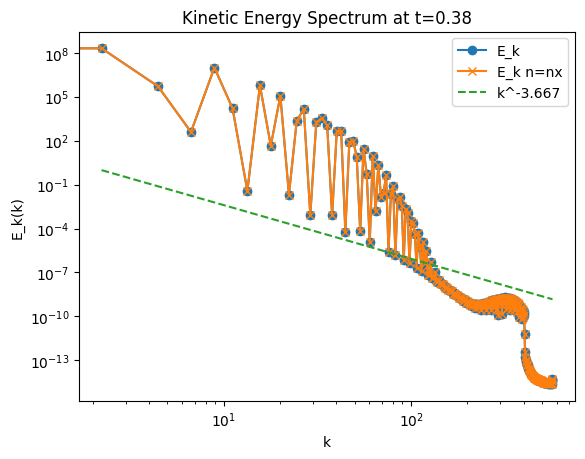

In [44]:
#it=0
it=-1

vfts  = np.fft.fft2(state.Pvecs[it,1:4,*state.imasksl],axes=(1,2))
vfts2  = np.fft.fft2(state.Pvecs[it,1:4,*state.imasksl],axes=(1,2), s=(state.nx,state.ny))
kftfreqsx = 2*np.pi*np.fft.fftfreq(state.nx,state.dx)
kftfreqsy = 2*np.pi*np.fft.fftfreq(state.ny,state.dy)
kftfreq_gridx, kftfreq_gridy = np.meshgrid(kftfreqsx, kftfreqsy, indexing='ij')
kftfreq_gridmag = np.sqrt(kftfreq_gridx**2 + kftfreq_gridy**2)
P_kin = 0.5*np.sum(vfts*np.conj(vfts),axis=0)
P_kin2 = 0.5*np.sum(vfts2*np.conj(vfts2),axis=0)
kmag_bins =np.shape(vfts)[2]
kmag_max = np.max(kftfreq_gridmag)
kmag_flat = np.linspace(0, kmag_max, kmag_bins, endpoint=True)
kmag_index = np.arange(kmag_bins)
k_idx = np.digitize(kftfreq_gridmag, kmag_flat) -1
P_kin_binned = np.array([np.mean(P_kin[k_idx == kmag_index[j]]) for j in range(kmag_bins)])
P_kin_binned2 = np.array([np.mean(P_kin2[k_idx == kmag_index[j]]) for j in range(kmag_bins)])



powplot=-(11/3)
itfix = 33
plt.figure()
plt.plot(kmag_flat, P_kin_binned.real, "-o", label='E_k')
plt.plot(kmag_flat, P_kin_binned2.real, "-x", label='E_k n=nx')
plt.plot(kmag_flat, (kmag_flat/kmag_flat[itfix])**powplot * P_kin_binned[itfix + 1].real, '--', label=f'k^{powplot:.3f}')
plt.legend()
plt.xlabel('k')
plt.ylabel('E_k(k)')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Kinetic Energy Spectrum at t={state.ts[it]:.2f}')


In [20]:
np.shape(vfts)

(29, 3, 256, 256)

In [19]:
kmag_flat

array([ 0.        , 45.254834  , 90.50966799])

In [14]:
np.shape(state.Pvecs[:,1:4,*state.imasksl])

(29, 3, 256, 256)

In [ ]:
import pyamg 
it=0
gal = pyamg.gallery.poisson((state.nx, state.ny), format='lil')
gal[-1,0] = gal[-1,0] = -1.0 #periodic
print(gal.toarray())
ml = pyamg.ruge_stuben_solver(gal)
time1 = time.time()
phi = ml.solve((state.Pvecs[it,0,state.imask] - np.mean(state.Pvecs[it,0,state.imask])).flatten()*4*np.pi, tol=1e-10)
time2 = time.time()
phi = phi.reshape((state.nx,state.ny))
print(f'Solver time: {time2 - time1:.4f} seconds')
plt.figure()
plt.imshow(phi.T, extent=(state.x0,state.x1,state.y0,state.y1), origin='lower')
plt.figure()
plt.imshow(4*np.pi*(state.Pvecs[it,0,state.imask] - np.mean(state.Pvecs[it,0,state.imask])).reshape((state.nx,state.ny)).T,  extent=(state.x0,state.x1,state.y0,state.y1), origin='lower')
plt.colorbar()

In [ ]:
import h5py
with h5py.File(r"C:\Users\nickd\PyFluid\checkpoints\2DKHa0\UPvec_0000.h5", "r") as f:
    print(list(f.keys()))
    for g in f:
        if isinstance(f[g], h5py.Group):
            print(g, list(f[g].keys())[:3], f[g].attrs.get("time"))

In [ ]:
it+=1
#it=-1
divb = np.gradient(state.Pvecs[it,5, :], state.dx, axis=0) + np.gradient(state.Pvecs[it,6, :], state.dx, axis=1)
plt.imshow(divb.T, extent=(state.x0, state.x1, state.y0, state.y1), origin='lower')
print(np.sum(np.abs(divb[*state.imasksl]))*state.dx*state.dy)
plt.colorbar()
plt.figure()

plt.imshow(state.Pvecs[it,5,...].T)

#state.LRBT_recon_UP(state.Uvecs[it,...], state.Pvecs[it,...], state.UvecintxL, state.UvecintxR, state.UvecintyB, state.UvecintyT, \
                    #state.PvecintxL, state.PvecintxR, state.PvecintyB, state.PvecintyT)
#divb2 = state.Pvecin
divb3 = (state.Pvecs[it,5,1:,1:] + state.Pvecs[it,5,1:,0:-1] - state.Pvecs[it,5,0:-1,1:] - state.Pvecs[it,5,0:-1,0:-1])/(2*state.dx) + \
            (state.Pvecs[it,6,1:,1:] + state.Pvecs[it,6,0:-1,1:] - state.Pvecs[it,6,1:,0:-1] - state.Pvecs[it,6,0:-1,0:-1])/(2*state.dy)
sl1 = slice(state.ng-1, - (state.ng+1))
sl2d = (sl1, sl1)
#print(np.sum(divb3[*sl2d]*(state.dx*state.dy)))
plt.figure()
plt.imshow(divb3[*sl2d].T, extent=(state.x0, state.x1, state.y0, state.y1), origin='lower')
plt.colorbar()
print(np.sum(np.abs(divb3[*sl2d]))*(state.dx*state.dy))

In [ ]:
state.diagnostics[:,-1]

In [ ]:
#it=0
it+=1
plt.imshow(state.Uvecs[it,2,:,:].T)
#plt.plot(state.Uvecs[it,0,128,:])

In [ ]:
state.Uvecs[0,0,:]
state.weno_eps = 1e-7
def LRreconV_weno4(vvecf, vvecintLf, vvecintRf):
    gf_Imm = vvecf[:, state.ng-3:-(state.ng+1)]  # v_{i-3}
    gf_Im = vvecf[:, state.ng-2:-(state.ng)]   # v_{i-2}
    gf_I = vvecf[:, state.ng-1:-(state.ng-1)]
    gf_Ip = vvecf[:, state.ng:state.outeri]     # v_{i+1}
    gf_Ipp = vvecf[:, state.ng+1:state.outeri3]  # v_{i+2}

    betaZ0 = (13/12) * (gf_Imm - 2*gf_Im + gf_I)**2 \
        + (1/4) * (gf_Imm - 4*gf_Im + 3*gf_I)**2
    betaZ1 = (13/12) * (gf_Im - 2*gf_I + gf_Ip)**2 \
        + (1/4) * (gf_Im - gf_Ip)**2
    betaZ2  = (13/12) * (gf_I - 2*gf_Ip + gf_Ipp)**2 \
        + (1/4) * (3*gf_I - 4*gf_Ip + gf_Ipp)**2
    tau5 = np.abs(betaZ0 - betaZ2)
    aux_alphaZ0 = 1.0 + tau5 /  (state.weno_eps + betaZ0)
    aux_alphaZ1 = 6.0 + tau5 /  (state.weno_eps + betaZ1)
    aux_alphaZ2 = 3.0 + tau5 /  (state.weno_eps + betaZ2)
    weight = np.array([3.0, 6.0, 1.0])/10.0
    alphaZ0m = aux_alphaZ0 * weight[0]
    alphaZ1m = aux_alphaZ1 * weight[1]
    alphaZ2m = aux_alphaZ2 * weight[2]
    alphaZ0p = aux_alphaZ0 * weight[2]
    alphaZ1p = aux_alphaZ1 * weight[1]
    alphaZ2p = aux_alphaZ2 * weight[0]
    sum_alphaZm = alphaZ0m + alphaZ1m + alphaZ2m
    sum_alphaZp = alphaZ0p + alphaZ1p + alphaZ2p
    omegaZ0m = alphaZ0m / sum_alphaZm
    omegaZ1m = alphaZ1m / sum_alphaZm   
    omegaZ2m = alphaZ2m / sum_alphaZm
    omegaZ0p = alphaZ0p / sum_alphaZp
    omegaZ1p = alphaZ1p / sum_alphaZp
    omegaZ2p = alphaZ2p / sum_alphaZp
    vvecintLf[...] = ((omegaZ2m / 6.0) * (2.0 * gf_Ipp - 7.0 * gf_Ip + 11.0 * gf_I) +\
                     (omegaZ1m / 6.0) * (-1.0 * gf_Ip + 5.0 * gf_I + 2.0 * gf_Im)  +\
                     (omegaZ0m / 6.0) * (2.0 * gf_I + 5.0 * gf_Im - 1.0 * gf_Imm))[:, 1:]
    vvecintRf[...] = ((omegaZ0p / 6.0) * (2.0 * gf_Imm - 7.0 * gf_Im + 11.0 * gf_I) +\
                     (omegaZ1p / 6.0) * (-1.0 * gf_Im + 5.0 * gf_I + 2.0 * gf_Ip) +\
                     (omegaZ2p / 6.0) * (2.0 * gf_I + 5.0 * gf_Ip - 1.0 * gf_Ipp))[:, :-1]
    
    
#LRreconV_weno4(state.Pvecs[0,], state.PvecintL, state.PvecintR)

plt.plot(state.xg, state.Pvecs[0,4,:],'-o', label='Initial Condition')
plt.plot(state.xgi, state.PvecintL[4,:],'-o', label='Left')
plt.plot(state.xgi, state.PvecintR[4,:],'-o', label='Right')
plt.legend()
plt.xlim(-0.05,0.05)

In [ ]:
state.hardreset_state()
state.apply_ics()
state.step_in_time()
state.apply_bcsU(state.Uvec,state.Pvec)
state.dt *= 0.01
state.diffstepmax = 1e4
state.diff_update()
state.differr

In [ ]:
plt.plot(state.PvecintL[4,:],'-o')

In [ ]:
#it = 0
it += 1
plt.plot(state.xg,state.Pvecs[it,0,:])
#plt.ylim(np.min(state.Pvecs[0,0,:])*0.9999,np.max(state.Pvecs[0,0,:])*1.0001)

In [ ]:
#it=0
it+=10
plt.plot(state.xg,state.Uvecs[it,0,:], "-o")
plt.plot(state.xghr,state.Uvecexacts[it,0,:],"--")
xintL = 0 - state.csL*state.ts[it]
xintR1 = state.vFanright*state.ts[it]
xintR2 = 0 + state.vContact*state.ts[it]
xintR3 = state.vShock*state.ts[it]
plt.scatter(xintL,state.rhoPv0[0],color='red',s=100,marker='x',label='Left Exact')
plt.scatter(xintR1,state.rho3,color='blue',s=100,marker='o',label='Right Exact')
plt.scatter(xintR2,state.rho3,color='green',s=100,marker='^',label='Contact Exact')
plt.axvline(x=xintL,color='red',linestyle='--',label = "Fan left")
plt.axvline(x=xintR1,color='blue',linestyle='--',label='Fan right')
plt.axvline(x=xintR2,color='green',linestyle='--',label='Contact Exact')
plt.axvline(x=xintR3,color='purple',linestyle='--',label='Shock Exact')
plt.axvline(x= 0,color='black',linestyle='--',label='Initial Discontinuity')
#plt.axhline(y = state.rho3)
#plt.axhline(y = state.rho4)

#plt.axhline
plt.legend()
#plt.plot(state.xgi,state.UvecintL[0,:],"-x",label='Left')
#plt.plot(state.xgi,state.UvecintR[0,:],'o',label='Right')
#plt.legend()
#plt.xlim(-0.05,0.05)
##plt.ylim(0.988,0.9924)
plt.title(f'Density Reconstruction at Interfaces, it = {it}')

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML



frames=100
framestep = 10;
framei = np.arange(frames)*framestep
fstopt = framei[-1]+1
save = True;
if framei[-1] > state.nsteps-1:
   raise ValueError("Too many frames for number of timesteps.")

if state.boolmag:
   nplots = 16
   nrows = 4
else:
   nplots = 12
   nrows = 3
fig, axs = plt.subplots(nrows, 4, figsize=(16, nplots))
suptitle = fig.suptitle(f"All Vars, t = {state.ts[framei[0]]}, it = {framei[0]}", fontsize=12)

delfix = 1e-10 
means = state.Uvecs.mean(axis = (0,2)) #
stds = state.Uvecs.std(axis = (0,2)) #
#ymins = means - 2*stds - delfix; ymaxs = means + 2*stds + delfix;
ymins = np.min(state.Uvecs[:fstopt,:,:],axis=(0,2)) - delfix - stds/6; ymaxs = np.max(state.Uvecs[:fstopt,:,:],axis=(0,2)) + delfix + stds/6;

meansdiags = state.diagnostics.mean(axis=0)
stdsdiags = state.diagnostics.std(axis=0)
#yminsdiags = meansdiags - 2*stdsdiags - delfix; ymaxsdiags = meansdiags + 2*stdsdiags + delfix;
yminsdiags = np.min(state.diagnostics[:fstopt,:],axis=0) - delfix - stdsdiags/6; ymaxsdiags = np.max(state.diagnostics[:fstopt,:],axis=0) + delfix + stdsdiags/6;

meansprims = state.Pvecs.mean(axis=(0,2))
stdsprims = state.Pvecs.std(axis=(0,2))
#yminsaux = meansaux - 2*stdsaux - delfix; ymaxsaux = meansaux + 2*stdsaux + delfix;
yminsprims = np.min(state.Pvecs[:fstopt,:,:],axis=(0,2)) - delfix - stdsprims/6; ymaxsprims = np.max(state.Pvecs[:fstopt,:,:],axis=(0,2)) + delfix + stdsprims/6;
#Animation 4x4 plots. (rho, rhovx,rhovy/rhovz, total rhovx/rhovy/rhovz), (E,m, total energy, total mass), (P, KE, total P/gamma-1, total KE),
# (By,Bz, MagE, total MagE). Totals are animated lines moving to the right in time.
# to fix in case of zero std
if True:
   line1rho = axs[0,0].plot([],[],label='Density')[0]
   if state.ici == 0:
      line1rhoexact = axs[0,0].plot([],[],label='Exact',color='black',ls='--')[0]
      line2rhovxexact = axs[0,1].plot([],[],label='Exact',color='black',ls='--')[0]
      line5rhovxtotexact = axs[0,3].plot([],[],label='Exact',color='black',ls='--')[0]
      line8Eexact = axs[1,0].plot([],[],label='Exact',color='black',ls='--')[0]
      line9Pexact = axs[1,1].plot([],[],label='Exact',color='black',ls='--')[0]
      line10massexact = axs[1,2].plot([],[],label='Exact',color='black',ls='--')[0]
      line11Etexact = axs[1,3].plot([],[],label='Exact',color='black',ls='--')[0]
      line12KEexact = axs[2,1].plot([],[],label='Exact',color='black',ls='--')[0]
      line13utotexact = axs[2,2].plot([],[],label='Exact',color='black',ls='--')[0]
      line14KEtotexact = axs[2,3].plot([],[],label='Exact',color='black',ls='--')[0]
   line2rhovx = axs[0,1].plot([],[],label='Momentum x',color='orange')[0]
   line3rhovy = axs[0,2].plot([],[],label='Momentum y',color='green')[0]
   line4rhovz = axs[0,2].plot([],[],label='Momentum z',color='red')[0]
   line5rhovxtot = axs[0,3].plot([],[],label='Total Momentum x',color='blue')[0]
   line6rhovytot = axs[0,3].plot([],[],label='Total Momentum y',color='green')[0]
   line7rhovztot = axs[0,3].plot([],[],label='Total Momentum z',color='red')[0]


   line8E = axs[1,0].plot([],[],label='Energy',color='purple')[0]
   line9P = axs[1,1].plot([],[],label='Pressure',color='cyan')[0]
   line10mass = axs[1,2].plot([],[],label='Mass',color='blue')[0]
   line11Etot = axs[1,3].plot([],[],label='Total Energy',color='blue')[0]


   line12vx = axs[2,1].plot([],[],label='Velocity x',color='grey')[0]
   line13utot = axs[2,2].plot([],[],label='Total internal Energy',color='blue')[0]
   line14KEtot = axs[2,3].plot([],[],label='Total Kinetic Energy',color='orange')[0]


   if state.boolmag:
      line15By = axs[3,0].plot([],[],label='By',color='brown')[0]
      line16Bz = axs[3,1].plot([],[],label='Bz',color='pink')[0]
      line17ME = axs[3,2].plot([],[],label='Magnetic Energy',color='black')[0]
      line18MEtot = axs[3,3].plot([],[],label='Total Magnetic Energy',color='blue')[0]

   axs[0,0].set_ylim(ymins[0],ymaxs[0])#rho
   axs[0,1].set_ylim(ymins[1],ymaxs[1])#rhovx
   axs[0,2].set_ylim(ymins[2],ymaxs[2])#rhovy
   axs[0,3].set_ylim(yminsdiags[3],ymaxsdiags[3])#total rhovx

   axs[1,0].set_ylim(ymins[4],ymaxs[4])#E
   axs[1,1].set_ylim(yminsprims[4],ymaxsprims[4])#P
   axs[1,2].set_ylim(yminsdiags[0],ymaxsdiags[0])#total mass
   axs[1,3].set_ylim(yminsdiags[1],ymaxsdiags[1])#total energy

   axs[2,1].set_ylim(yminsprims[1],ymaxsprims[1])#velocity 
   axs[2,2].set_ylim(yminsdiags[2],ymaxsdiags[2])#total internal energy
   
   axs[2,3].set_ylim(yminsdiags[10],ymaxsdiags[10])#total kinetic energy
   if state.boolmag:
      axs[3,0].set_ylim(ymins[5],ymaxs[5])#By
      axs[3,1].set_ylim(ymins[6],ymaxs[6])#Bz
      axs[3,2].set_ylim(yminsaux[7],ymaxsaux[7])#MagE
      axs[3,3].set_ylim(yminsdiags[9],ymaxsdiags[9])#total MagE
   for idx,ax  in enumerate(axs.flat):
      if idx in [3,6,7,10,11,15]:
         ax.set_xlabel('Time (t)')
         ax.set_xlim(state.ts[framei[0]],state.ts[framei[-1]])
      else:
         ax.set_xlabel('x')
         ax.set_xlim(state.xg[0],state.xg[-1])
      # if idx in [2,3]:
      #    plt.legend()

   if state.boolmag:
      lines = [line1rho,line2rhovx,line3rhovy,line4rhovz,line5rhovxtot,line6rhovytot,line7rhovztot,
               line8E,line9P,line10mass,line11Etot,line12vx,line13utot,line14KEtot,line15By,line16Bz,line17ME,line18MEtot]
   else:
      lines = [line1rho,line2rhovx,line3rhovy,line4rhovz,line5rhovxtot,line6rhovytot,line7rhovztot,
               line8E,line9P,line10mass,line11Etot,line12vx,line13utot,line14KEtot]
   if state.ici == 0:
      lines = [*lines, line1rhoexact,line2rhovxexact,line5rhovxtotexact,
               line8Eexact,line9Pexact,line10massexact,line11Etexact,line12KEexact,line13utotexact,line14KEtotexact]

plt.tight_layout()

def init():
   titles = ['Density(x)', 'Momentum x(x)', 'Momentum y,z(x)', 'Total Momentum x,y,z(t)',
              'Energy(x)', 'Pressure(x)','Total Mass(t)', 'Total Energy(t)',
             '', 'Velocity x (x)', 'Total Int. E(t)', 'Total Kin. E(t)',
             'By(x)', 'Bz(x)', 'Magnetic Energy(x)', 'Total Magnetic Energy(t)']
   if state.boolmag:
      pass
   else:
      titles = titles[0:-4]
             
   for idx, ax in enumerate(axs.flat):
      ax.set_title(titles[idx])
   for line in lines:
      line.set_data([], [])
   return lines

def animate(frame):
   lines[0].set_data(state.xg, state.Uvecs[frame, 0, :]) #rho
   lines[1].set_data(state.xg, state.Uvecs[frame, 1, :]) #rhovx
   lines[2].set_data(state.xg, state.Uvecs[frame, 2, :]) #rhovy
   lines[3].set_data(state.xg, state.Uvecs[frame, 3, :]) #rhovz
   lines[4].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 2]) #total rhovx
   lines[5].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 3]) #total rhovy
   lines[6].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 4]) #total rhovz
   lines[7].set_data(state.xg, state.Uvecs[frame, 4, :]) #E
   lines[8].set_data(state.xg, state.Pvecs[frame, 4, :]) #P
   lines[9].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 0]) #total mass
   lines[10].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 1]) #total energy
   lines[11].set_data(state.xg, state.Pvecs[frame, 1, :]) #vx
   lines[12].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 2]) #total internal energy
   lines[13].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 10]) #total kinetic energy
   if state.ici == 0:
      lines[14].set_data(state.xghr, state.Uvecexacts[frame, 0, :]) #rho exact
      lines[15].set_data(state.xghr, state.Uvecexacts[frame, 1, :]) #rhovx exact
      lines[16].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 3]) #total rhovx exact
      lines[17].set_data(state.xghr, state.Uvecexacts[frame, 4, :]) #E exact
      lines[18].set_data(state.xghr, state.Pvecexacts[frame, 4, :]) #P exact
      lines[19].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 0]) #total mass exact
      lines[20].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 1]) #total energy exact
      lines[21].set_data(state.xghr, state.Pvecexacts[frame, 1, :]) #vx exact
      lines[22].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 2]) #total internal energy exact
      lines[23].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 10]) #total kinetic energy exact
   if state.boolmag:#(mass, energy, internal energy, rhovx, rhovy, rhovz, rhov, gradP, lapP, magE, KE)
      lines[14].set_data(state.xg, state.Uvecs[frame, 5, :]) #By
      lines[15].set_data(state.xg, state.Uvecs[frame, 6, :]) #Bz
      lines[16].set_data(state.xg, state.Auxvecs[frame, 7, :]) #magE
      lines[17].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 9]) #total magE
   suptitle.set_text(f"All Vars, t = {state.ts[frame]:.3f}, it = {frame}")
   return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=framei, interval=35, blit=True)
HTML(anim.to_jshtml())
if save:
   anim.save(gifdir + f"anim{state.icname}.mp4", fps=15)


In [ ]:
#it = 0
it +=10
plt.plot(state.Uvecs[it,0,:], "-o")